In [1]:
# pytorch requirements
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm

# other requirements
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import numpy as np
import pandas as pd

import os
import random

# custom
#from utils import set_all_seeds, load_dataset
#from config import Config

#-----------------------------
%matplotlib inline

In [7]:
def gpu_info():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print(torch.cuda.device_count())
gpu_info()

GeForce RTX 2080 Ti
4


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
#----------utilities---------------------
# loading the dataset------------------------------------------
def load_dataset(batch_size):
    # loading the MNIST dataset
    train_set = datasets.MNIST(root = 'data', train = True, download = False, transform = transforms.ToTensor())
    test_set = datasets.MNIST(root = 'data', train = False, download = False, transform = transforms.ToTensor())

    # Setting up the dataloaders
    train_dataloader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
    test_dataloader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = True)
    
    return train_dataloader, test_dataloader
    
# setting random seeds-----------------------------------------
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [10]:
class VRNN(nn.Module):
    def __init__(self, x_dim, h_dim, z_dim, n_layers):
        super(VRNN, self).__init__()
        
        self.x_dim = x_dim
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.n_layers = n_layers
        
        # feature extractions
        # extracting features of the input x<t> 
        self.phi_x = nn.Sequential(
            nn.Linear(x_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU()
        )
        
        # extracting features of the the latent variable z<t>
        self.phi_z = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU()
        )
        
        # encoder
        self.encoder = nn.Sequential(
            #nn.Linear(h_dim + h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(2*h_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU()
        )
        
        self.encoder_mean = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, z_dim),
        )
        
        self.encoder_var = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, z_dim),
            nn.Softplus()
        )
        
        # prior distribution and its parameters
        self.prior = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU()
        )
        
        self.prior_mean = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, z_dim)
        )
        
        self.prior_var = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, z_dim),
            nn.Softplus()
        )
        
        # decoder
        self.decoder = nn.Sequential(
            #nn.Linear(h_dim + h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(2*h_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU()
        )
        
        self.decoder_mean = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, x_dim),
            nn.Sigmoid()
        )
        self.decoder_var = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, x_dim),
            nn.Softplus()
        )
        
        # recurrence
        self.rnn = nn.GRU(h_dim + h_dim, h_dim, n_layers)
        #self.rnn = nn.LSTM(h_dim + h_dim, h_dim, n_layers)
        
        
    def inference(self, phi_x_t, ht_minus_1):
        
        # returns the parameters of the posterior distribution
        
        encoder_input = torch.cat([phi_x_t, ht_minus_1], dim=1)
        encoder_t = self.encoder(encoder_input)
        encoder_mean_t = self.encoder_mean(encoder_t)
        encoder_var_t = self.encoder_var(encoder_t)
        
        return encoder_mean_t, encoder_var_t
    
    
    def generation_z(self, ht_minus_1):
        
        # returns the parameters of the prior distribution
        
        prior_t = self.prior(ht_minus_1)
        prior_mean_t = self.prior_mean(prior_t)
        prior_var_t = self.prior_var(prior_t)
        
        return prior_mean_t, prior_var_t
    
    
    def generation_x(self, phi_z_t, ht_minus_1):
        
        # returns the parameters of the output distribution
        
        decoder_input = torch.cat([phi_z_t, ht_minus_1], dim=1)
        decoder_t = self.decoder(decoder_input)
        decoder_mean_t = self.decoder_mean(decoder_t)
        decoder_var_t = self.decoder_var(decoder_t)
        
        return decoder_mean_t, decoder_var_t
    
    
    def recurrence(self, phi_x_t, phi_z_t, h, c=0):
        
        rnn_input = torch.cat([phi_x_t, phi_z_t], dim=1).unsqueeze(0)
        _, h = self.rnn(rnn_input, h) # gru
        #_, (h,c) = self.rnn(rnn_input, (h,c)) # lstm
        
        return h
    
    
    def reparameterize(self, *args):
        z_mean, z_log_var = args
        
        # sampling from a standard normal distribution
        #eps = torch.randn(z_mean.size(0), z_mean.size(1)).to(device)
        
        # creating a random variable z drawn from a normal distribution having parameters z_mu and z_log_var
        #z = z_mean + eps*torch.exp(z_log_var/2.)

        eps = torch.FloatTensor(z_log_var.size()).normal_().to(device)
        return eps.mul(z_log_var).add_(z_mean)
        #return z

    
    
    def forward(self, x):
        
        all_encoder_mean, all_encoder_var = [], []
        all_prior_mean, all_prior_var = [], []
        all_decoder_mean, all_decoder_var = [], []
        
        timesteps = x.size(1) # timesteps = 28  (x is of shape = (batch_size, 28, 28))
        h = torch.zeros([self.n_layers, x.size(0), self.h_dim], device = x.device) # no_of_layers x batch_size x h_dim
        #c = torch.zeros([self.n_layers, x.size(0), self.h_dim], device = x.device) # cell state if using lstm
        
        for t in range(timesteps):
            
            # feature extraction for x_t
            phi_x_t = self.phi_x(x[:, t, :])   # x[:, t, :] has dimensions (batch_size, 28)
        
            # encoder
            encoder_mean_t, encoder_var_t = self.inference(phi_x_t, h[-1])
            
            # reparameterization
            z_t = self.reparameterize(encoder_mean_t, encoder_var_t)
            
            # feature extraction for z_t
            phi_z_t = self.phi_z(z_t)
            
            # decoder
            decoder_mean_t, decoder_var_t = self.generation_x(phi_z_t, h[-1])
            #print("decoder mean vector size: ",decoder_mean_t.size())  # (batch_size, 28)
                
            # prior
            prior_mean_t, prior_var_t = self.generation_z(h[-1]) # gru
            
            # recurrence
            h = self.recurrence(phi_x_t, phi_z_t, h)
            
            all_encoder_mean.append(encoder_mean_t)
            all_encoder_var.append(encoder_var_t)
            all_prior_mean.append(prior_mean_t)
            all_prior_var.append(prior_var_t)
            all_decoder_mean.append(decoder_mean_t)
            all_decoder_var.append(decoder_var_t)
            
        return [all_encoder_mean, all_encoder_var, all_prior_mean, all_prior_var, all_decoder_mean, all_decoder_var]
    
    
    # To sample from the prior distribution
    def sample(self, seq_len, device, get_latent_vector = False):
        
        sample = torch.zeros(seq_len, self.x_dim, device = device)
        h = torch.zeros(self.n_layers, 1, self.h_dim, device = device)
        #c = torch.zeros(self.n_layers, 1, self.h_dim, device = device) # cell state if using lstm
        
        if get_latent_vector == True:
            z = torch.zeros(seq_len, self.z_dim, device = device)
        
        for t in range(seq_len):
            
            # prior
            prior_mean_t, prior_var_t = self.generation_z(h[-1])
            
            # reparameterization
            z_t = self.reparameterize(prior_mean_t, prior_var_t)
             
            # stacking the latent vectors into a matrix 
            if get_latent_vector == True:
                z[t] = z_t.data
            
            # feature extraction for z_t
            phi_z_t = self.phi_z(z_t)
            
            # decoder
            decoder_mean_t, _ = self.generation_x(phi_z_t, h[-1])
            
            # sampling the x_t (the reconstructed output)
            #x_t = self.reparameterize(decoder_mean_t, decoder_var_t)
            
            #phi_x_t = self.phi_x(x_t)
            phi_x_t = self.phi_x(decoder_mean_t)
            
            # recurrence
            h = self.recurrence(phi_x_t, phi_z_t, h) # gru
            
            #print(x_t.data)
            sample[t] = decoder_mean_t.data
            #sample[t] = x_t.data
            
        if get_latent_vector == True:
            return sample, z
        return sample
    
 
    # To encode the th given input into it's latent representation
    def encode(self, x):
        
        timesteps = x.size(1)  # timesteps = 28  (x is of shape = (28, 28))
        h = torch.zeros([self.n_layers, 1, self.h_dim], device = x.device) # no_of_layers x batch_size x h_dim
        
        z = torch.zeros(timesteps, self.z_dim, device = x.device)
        
        for t in range(timesteps):    
            
            # feature extraction for x_t
            phi_x_t = self.phi_x(x[t].unsqueeze(0))  # x is (28,28), x[t] is (28,), x[t].unsqueeze(0) is (1,28)
            
            # encoder
            encoder_mean_t, encoder_var_t = self.inference(phi_x_t, h[-1])
            
            # reparameterization
            z_t = self.reparameterize(encoder_mean_t, encoder_var_t)
            
            z[t] = z_t.data
            
            # feature extraction for z_t
            phi_z_t = self.phi_z(z_t)
            
            # recurrence
            h = self.recurrence(phi_x_t, phi_z_t, h) # gru
            
        return z
    
    
    # for reconstructing the output from the given input by samping latent vector from posterior distribution
    def reconstruction_from_posterior(self, x):
        
        timesteps = x.size(1)  # timesteps = 28  (x is of shape = (28, 28))
        h = torch.zeros([self.n_layers, 1, self.h_dim], device = x.device) # no_of_layers x batch_size x h_dim
        
        seq_len = x.size(1)
        sample_post = torch.zeros(seq_len, self.x_dim, device = x.device)
        
        for t in range(timesteps):
            
            # feature extraction for x_t
            phi_x_t = self.phi_x(x[t].unsqueeze(0))  # x is (28,28), x[t] is (28,), x[t].unsqueeze(0) is (1,28)
            
            # encoder
            encoder_mean_t, encoder_var_t = self.inference(phi_x_t, h[-1])
            
            # reparameterization
            z_t = self.reparameterize(encoder_mean_t, encoder_var_t)
            
            # feature extraction for z_t
            phi_z_t = self.phi_z(z_t)
            
            # decoder
            decoder_mean_t, decoder_var_t = self.generation_x(phi_z_t, h[-1])
            
            # recurrence
            h = self.recurrence(phi_x_t, phi_z_t, h)
            
            sample_post[t] = decoder_mean_t.data
            
        return sample_post
            

In [11]:
import torch
import torch.distributions.normal as Norm
import torch.distributions.kl as KL
import torch.nn.functional as F
import numpy as np

In [12]:
class Losses:
    def __init__(self, device):
        self.small = torch.tensor([1e-10]).to(device)
    
    def _kld_gauss(self, mean_1, std_1, mean_2, std_2):
        kld_element =  (2 * torch.log(torch.max(std_2,self.small)) - 2 * torch.log(torch.max(std_1,self.small)) + (std_1.pow(2) + (mean_1 - mean_2).pow(2)) /(std_2.pow(2)+1e-10) - 1)
        return 0.5 * torch.sum(kld_element)    
    
    def KLD_loss(mean_1, std_1, mean_2, std_2):
        ret = -0.5 * torch.sum(std_1 - std_2 - torch.div(std_1.exp() + (mean_1 - mean_2).pow(2), std_2.exp()+1e-10))
        return ret
    
    def kl_type_1(self, mean_1, std_1, mean_2, std_2):
        KL_loss = self._kld_gauss(mean_1, std_1, mean_2, std_2)
        return KL_loss
    
    def kl_type_2(self, mean_1, std_1, mean_2, std_2):
        norm_dist_1 = Norm.Normal(mean_1, std_1)
        norm_dist_2 = Norm.Normal(mean_2, std_2)
        KL_loss = torch.mean(KL.kl_divergence(norm_dist_2, norm_dist_1))
        return KL_loss
    
    def kl_type_3(self, mean_1, std_1, mean_2, std_2):
        KL_loss = self.KLD_loss(mean_1, std_1, mean_2, std_2)
        return KL_loss
    
    def _nll_bernoulli(self, x, theta):
        return - torch.sum(x*torch.log(torch.max(theta, self.small)) + (1-x)*torch.log(torch.max(1-theta, self.small)))
    
    def Gaussian_nll(self, y, mu, sig):
        #nll = 0.5 * torch.sum(torch.square(y - mu) / sig**2 + 2 * torch.log(sig) + torch.log(torch.tensor(2 * np.pi)), axis=-1)
        nll = 0.5 * torch.sum(torch.square(y - mu) / (sig**2+1e-10) + 2 * torch.log(torch.max(sig,self.small)) + torch.log(torch.tensor(2 * np.pi)))
        return nll
    
    def recons_type_1(self, x, theta):
        recons_loss = _nll_bernoulli(x, theta)
        return recons_loss
    
    def recons_type_2(self, x, theta):
        recons_loss = torch.mean(F.binary_cross_entropy(theta, x, reduction = 'none'))
        return recons_loss
    
    def recons_type_3(self, y, mu, sig):
        recons_loss = Gaussian_nll(y, mu, sig)
        #recons_loss = torch.mean(recons_loss) # when axis axis=-1 in Gaussian_nll
        return recons_loss 

In [13]:
losses = Losses(device)

In [14]:
def loss_function(dist_params, x):
    
    encoder_mean, encoder_var, prior_mean, prior_var, decoder_mean, decoder_var = dist_params
    loss = 0.
    KL_loss_=0.
    recons_loss_=0.
    
    timesteps = x.size(1)
    
    for t in range(timesteps):
        
        # KL loss-------------------------------------------------------------------------------
        
        KL_loss = losses.kl_type_1(encoder_mean[t], encoder_var[t], prior_mean[t], prior_var[t])
        #KL_loss = losses.kl_type_2(encoder_mean[t], encoder_var[t], prior_mean[t], prior_var[t])
        #KL_loss = losses.kl_type_3(encoder_mean[t], encoder_var[t], prior_mean[t], prior_var[t])
        
        # reconstruction loss-------------------------------------------------------------------
        
        recons_loss = losses.recons_type_1(x[:, t, :], decoder_mean[t])
        #recons_loss = losses.recons_type_2(x[:, t, :], decoder_mean[t])
        #recons_loss = losses.recons_type_3(x[:, t, :], decoder_mean[t], decoder_var[t])
        
        #------------------------------------------------------------------------------------------
        loss += recons_loss + KL_loss
        KL_loss_+=KL_loss
        recons_loss_+=recons_loss
    
    return loss, KL_loss_, recons_loss_

In [15]:
# Class for Early Stopping--------------------------------------
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='saves/checkpoint2.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [16]:

def train(model, train_dataloader, conf, epoch, device):
   
    model.train()
    size = len(train_dataloader.dataset)
    train_loss = 0
    
    for batch_idx, (x, _) in enumerate(train_dataloader):
        x = x.to(device)
        x = x.squeeze()   # x is of dimensions (batch_size, 1, 28, 28) --> after squeezing --> (batch_size, 28, 28)
        #x /= 255
        x = (x - x.min().item()) / (x.max().item() - x.min().item())
        
        #----------------forward----------------------
        dist_params = model(x)
        loss, kl_loss, recons_loss = loss_function(dist_params, x)
        train_loss += loss.item()
        
        
        #------------backward------------------------
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _ = nn.utils.clip_grad_norm_(model.parameters(), conf.clip)
        
        # ----------logging---------------
        if batch_idx % conf.print_every == 0:
            current = batch_idx*len(x)
            loss = loss.item()
            print(f"loss: {loss/conf.batch_size:>7f}  [{current:>5d}/{size:>5d}]") 
            print(f"KL_loss: {kl_loss.item()/conf.batch_size:.6f}, recons_loss: {recons_loss.item()/conf.batch_size:.6f}")
            
            # generating samples
            sample = model.sample(conf.x_dim, device)
            plt.imshow(sample.cpu().detach().numpy())
            plt.pause(1e-6)
            
        #break
    
    avg_train_loss = train_loss/size  # average training loss per epoch
    print('====> Average Train loss: {:.4f}'.format(avg_train_loss))
    
    return avg_train_loss
        

In [17]:
def test(model, test_dataloader, conf, epoch, device):
    
    model.eval()
    size = len(test_dataloader.dataset)
    test_loss = 0
    
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(test_dataloader):
            x = x.to(device)
            x = x.squeeze()
            #x /= 255
            x = (x - x.min().item()) / (x.max().item() - x.min().item())
        
            #-------forward----------------
            dist_params = model(x)
            loss,_,_ = loss_function(dist_params, x)
            
            '''
            if batch_idx % conf.print_every == 0:
                sample, z = model.sample(conf.x_dim, device)
                plt.imshow(sample.cpu().detach().numpy())
                plt.pause(1e-6)
            '''
            
            test_loss += loss.item()
    
    #--------logging-----------------
    avg_test_loss = test_loss/size  # average test loss per epoch
    print('====> Average Test loss: {:.4f}'.format(avg_test_loss))
    
    return avg_test_loss
        

In [18]:
def execute(model, train_dataoader, test_dataloader, conf, device):

    train_loss = []  # list of training losses for all epochs
    test_loss = []   # list of test losses for all epochs
    
    # instantiating the object of EarlyStopping class 
    early_stopping = EarlyStopping(patience=conf.patience, verbose=True)
    
    for ep in range(1, conf.n_epochs+1):
        
        print(f"Epoch {ep}\n-------------------------------")
        train_loss_per_epoch = train(model, train_dataloader, conf, ep, device)
        
        #break
        
        test_loss_per_epoch = test(model, test_dataloader, conf, ep, device)
        
        train_loss.append(train_loss_per_epoch)
        test_loss.append(test_loss_per_epoch)
        
        # saving model without early stopping
        """
        if ep % conf.save_every == 1:
            fn = 'saves/vrnn_state_dict_'+str(ep)+'.pt'
            torch.save(model.state_dict(), fn)
            print('Saved model to '+fn)
        """
        
        # early_stopping needs the validation/test loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(test_loss_per_epoch, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
            
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('saves/checkpoint2.pt'))
        
    print("Execution complete")
    
    return model, train_loss, test_loss

In [19]:
# configuration class for hyperparameters and other small things
class Config(object):
    
    def __init__(self):
        
        # hyperparameters
        self.x_dim = 28
        self.h_dim = 100
        self.z_dim = 16
        self.n_layers = 1
        self.n_epochs = 100
        self.clip = 10
        self.batch_size = 128
        self.learning_rate = 0.001
        self.patience = 5
        
        # other
        self.print_every = 100
        self.save_every = 10
        self.seed = 123
        self.device_ids = [0,1,2,3]

Epoch 1
-------------------------------
loss: 553.415039  [    0/60000]
KL_loss: 8.693548, recons_loss: 544.721558


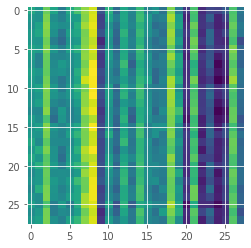

loss: 197.430695  [12800/60000]
KL_loss: 4.725726, recons_loss: 192.704987


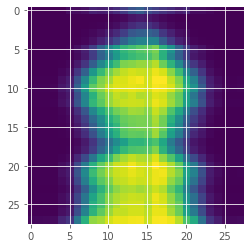

loss: 140.428741  [25600/60000]
KL_loss: 2.145824, recons_loss: 138.282913


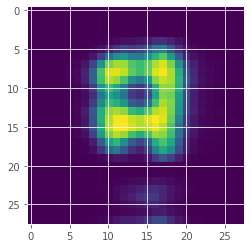

loss: 110.909775  [38400/60000]
KL_loss: 2.617331, recons_loss: 108.292442


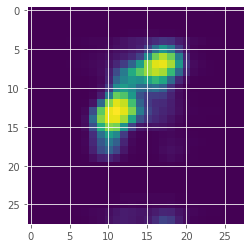

loss: 101.432503  [51200/60000]
KL_loss: 2.657303, recons_loss: 98.775208


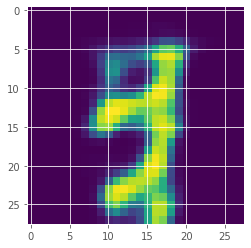

====> Average Train loss: 156.4744
====> Average Test loss: 94.9314
Validation loss decreased (inf --> 94.931416).  Saving model ...
Epoch 2
-------------------------------
loss: 96.154327  [    0/60000]
KL_loss: 2.504617, recons_loss: 93.649719


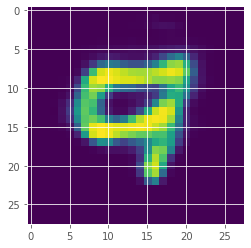

loss: 96.772469  [12800/60000]
KL_loss: 2.720721, recons_loss: 94.051735


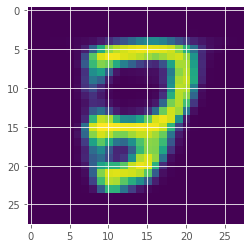

loss: 91.085861  [25600/60000]
KL_loss: 2.917851, recons_loss: 88.168007


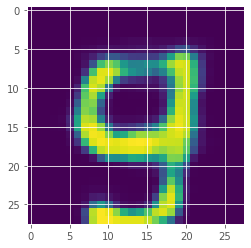

loss: 92.027397  [38400/60000]
KL_loss: 2.810711, recons_loss: 89.216667


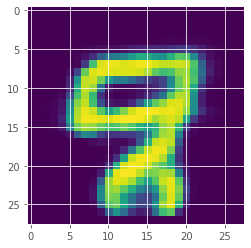

loss: 88.254913  [51200/60000]
KL_loss: 2.856900, recons_loss: 85.398003


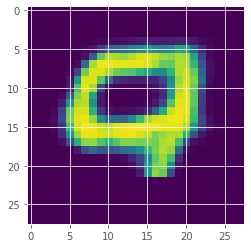

====> Average Train loss: 91.2025
====> Average Test loss: 86.9017
Validation loss decreased (94.931416 --> 86.901742).  Saving model ...
Epoch 3
-------------------------------
loss: 84.932541  [    0/60000]
KL_loss: 3.120592, recons_loss: 81.811958


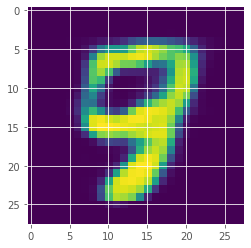

loss: 88.401741  [12800/60000]
KL_loss: 3.298586, recons_loss: 85.103157


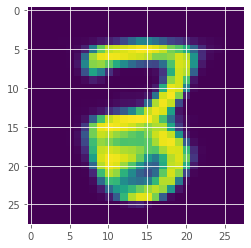

loss: 86.618530  [25600/60000]
KL_loss: 3.582315, recons_loss: 83.036209


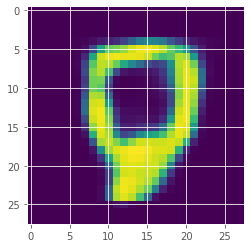

loss: 84.340302  [38400/60000]
KL_loss: 3.668248, recons_loss: 80.672058


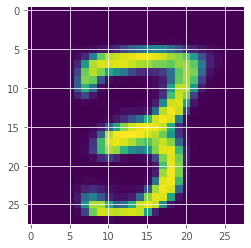

loss: 86.265266  [51200/60000]
KL_loss: 3.759584, recons_loss: 82.505684


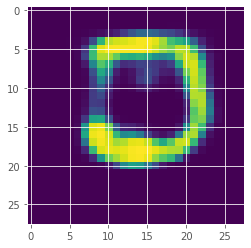

====> Average Train loss: 85.8324
====> Average Test loss: 83.2753
Validation loss decreased (86.901742 --> 83.275307).  Saving model ...
Epoch 4
-------------------------------
loss: 84.186821  [    0/60000]
KL_loss: 3.706677, recons_loss: 80.480141


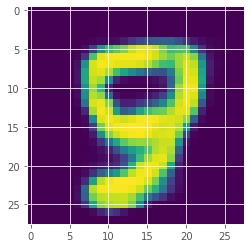

loss: 85.369759  [12800/60000]
KL_loss: 3.818243, recons_loss: 81.551514


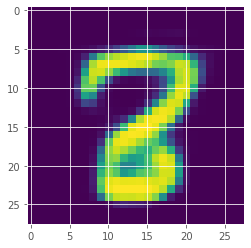

loss: 83.114853  [25600/60000]
KL_loss: 3.292823, recons_loss: 79.822021


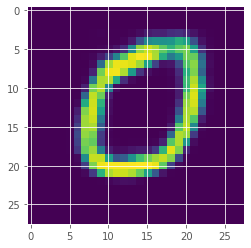

loss: 81.535332  [38400/60000]
KL_loss: 3.601030, recons_loss: 77.934303


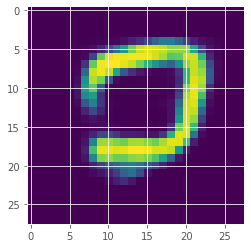

loss: 82.822731  [51200/60000]
KL_loss: 3.605481, recons_loss: 79.217270


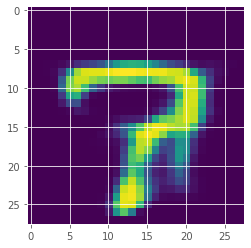

====> Average Train loss: 83.1404
====> Average Test loss: 81.3030
Validation loss decreased (83.275307 --> 81.302950).  Saving model ...
Epoch 5
-------------------------------
loss: 78.722565  [    0/60000]
KL_loss: 3.439893, recons_loss: 75.282661


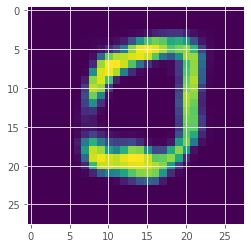

loss: 81.869415  [12800/60000]
KL_loss: 3.714601, recons_loss: 78.154808


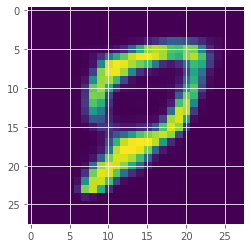

loss: 81.720764  [25600/60000]
KL_loss: 3.687455, recons_loss: 78.033318


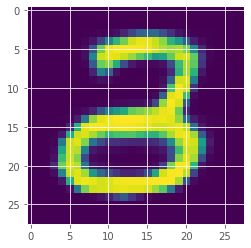

loss: 81.574219  [38400/60000]
KL_loss: 3.705197, recons_loss: 77.869003


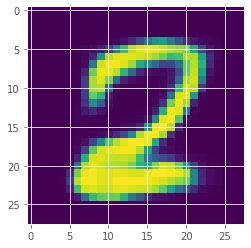

loss: 78.052544  [51200/60000]
KL_loss: 3.797086, recons_loss: 74.255455


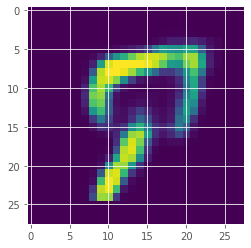

====> Average Train loss: 81.3881
====> Average Test loss: 79.8082
Validation loss decreased (81.302950 --> 79.808242).  Saving model ...
Epoch 6
-------------------------------
loss: 78.959991  [    0/60000]
KL_loss: 3.727688, recons_loss: 75.232307


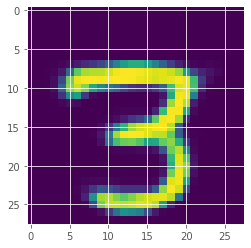

loss: 77.914642  [12800/60000]
KL_loss: 3.942018, recons_loss: 73.972626


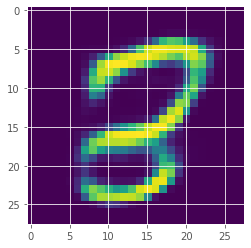

loss: 83.056580  [25600/60000]
KL_loss: 3.851719, recons_loss: 79.204857


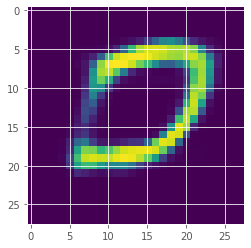

loss: 79.578423  [38400/60000]
KL_loss: 3.813011, recons_loss: 75.765396


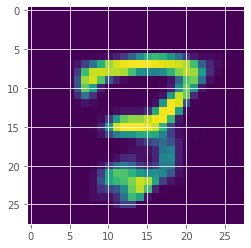

loss: 78.501778  [51200/60000]
KL_loss: 3.597630, recons_loss: 74.904144


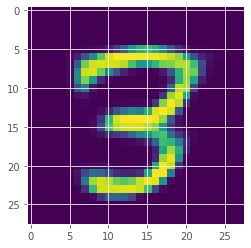

====> Average Train loss: 80.1626
====> Average Test loss: 78.9567
Validation loss decreased (79.808242 --> 78.956677).  Saving model ...
Epoch 7
-------------------------------
loss: 78.233620  [    0/60000]
KL_loss: 3.538949, recons_loss: 74.694679


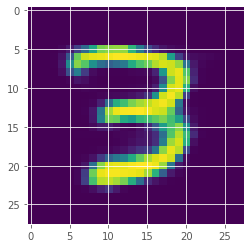

loss: 81.117271  [12800/60000]
KL_loss: 3.746332, recons_loss: 77.370956


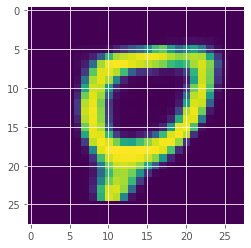

loss: 77.151978  [25600/60000]
KL_loss: 4.613109, recons_loss: 72.538857


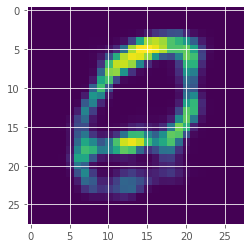

loss: 74.923607  [38400/60000]
KL_loss: 3.913352, recons_loss: 71.010262


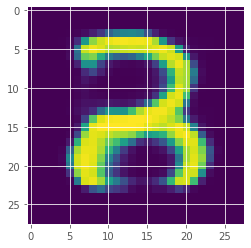

loss: 78.768440  [51200/60000]
KL_loss: 3.837976, recons_loss: 74.930443


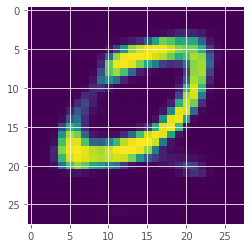

====> Average Train loss: 79.3628
====> Average Test loss: 78.2829
Validation loss decreased (78.956677 --> 78.282873).  Saving model ...
Epoch 8
-------------------------------
loss: 76.548035  [    0/60000]
KL_loss: 3.673186, recons_loss: 72.874855


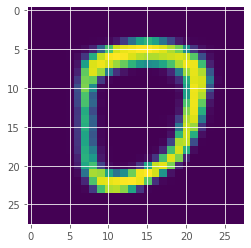

loss: 78.885925  [12800/60000]
KL_loss: 3.964075, recons_loss: 74.921837


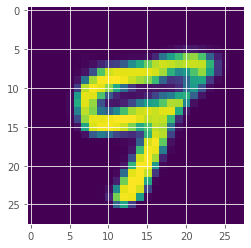

loss: 75.134224  [25600/60000]
KL_loss: 3.688363, recons_loss: 71.445862


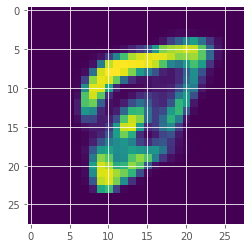

loss: 76.004807  [38400/60000]
KL_loss: 3.381274, recons_loss: 72.623543


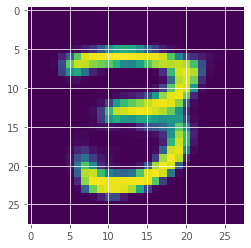

loss: 78.109520  [51200/60000]
KL_loss: 3.578825, recons_loss: 74.530678


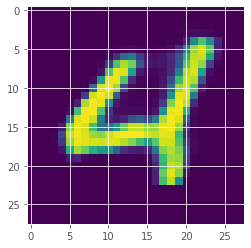

====> Average Train loss: 78.5757
====> Average Test loss: 77.8308
Validation loss decreased (78.282873 --> 77.830766).  Saving model ...
Epoch 9
-------------------------------
loss: 80.354019  [    0/60000]
KL_loss: 4.053676, recons_loss: 76.300339


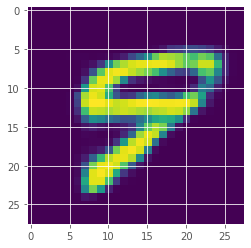

loss: 76.563812  [12800/60000]
KL_loss: 3.685044, recons_loss: 72.878761


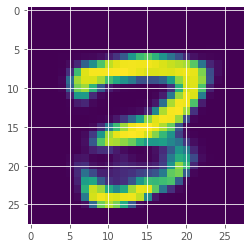

loss: 76.302383  [25600/60000]
KL_loss: 4.034363, recons_loss: 72.268021


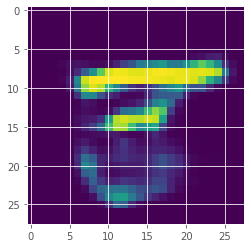

loss: 76.497963  [38400/60000]
KL_loss: 3.638806, recons_loss: 72.859161


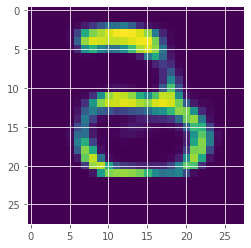

loss: 74.183022  [51200/60000]
KL_loss: 3.749496, recons_loss: 70.433525


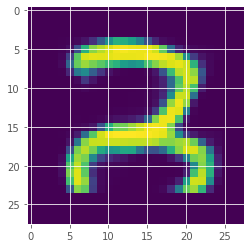

====> Average Train loss: 78.0312
====> Average Test loss: 76.7552
Validation loss decreased (77.830766 --> 76.755206).  Saving model ...
Epoch 10
-------------------------------
loss: 77.344772  [    0/60000]
KL_loss: 3.638277, recons_loss: 73.706482


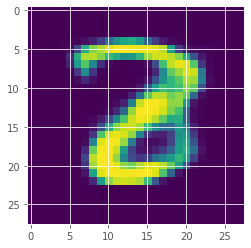

loss: 78.947075  [12800/60000]
KL_loss: 3.725101, recons_loss: 75.221962


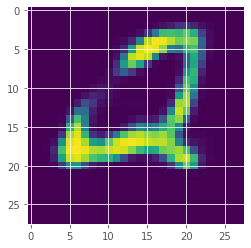

loss: 78.514580  [25600/60000]
KL_loss: 4.014428, recons_loss: 74.500160


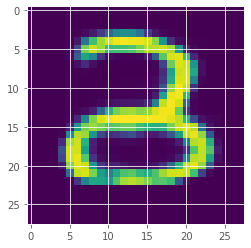

loss: 76.350868  [38400/60000]
KL_loss: 3.971220, recons_loss: 72.379646


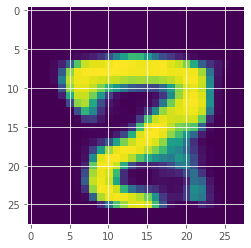

loss: 77.530800  [51200/60000]
KL_loss: 4.066678, recons_loss: 73.464134


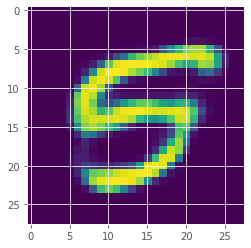

====> Average Train loss: 77.6257
====> Average Test loss: 76.5886
Validation loss decreased (76.755206 --> 76.588648).  Saving model ...
Epoch 11
-------------------------------
loss: 78.366058  [    0/60000]
KL_loss: 4.070035, recons_loss: 74.296028


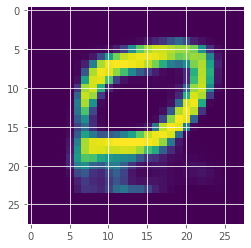

loss: 79.222198  [12800/60000]
KL_loss: 3.785125, recons_loss: 75.437073


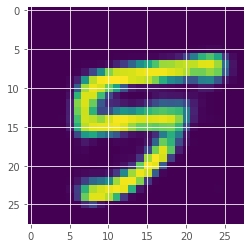

loss: 76.608093  [25600/60000]
KL_loss: 3.902847, recons_loss: 72.705246


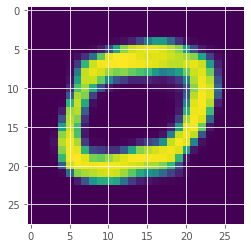

loss: 77.352127  [38400/60000]
KL_loss: 3.921240, recons_loss: 73.430901


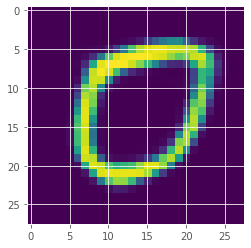

loss: 76.015686  [51200/60000]
KL_loss: 3.532828, recons_loss: 72.482864


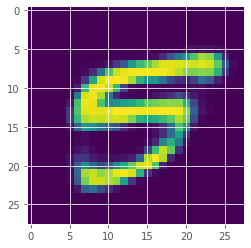

====> Average Train loss: 76.9749
====> Average Test loss: 77.7797
EarlyStopping counter: 1 out of 5
Epoch 12
-------------------------------
loss: 77.881996  [    0/60000]
KL_loss: 3.948411, recons_loss: 73.933594


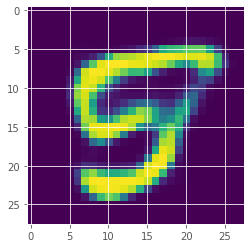

loss: 78.014725  [12800/60000]
KL_loss: 3.788706, recons_loss: 74.226013


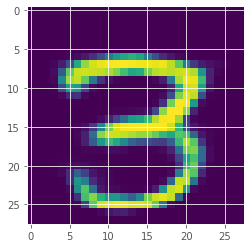

loss: 77.485527  [25600/60000]
KL_loss: 3.895696, recons_loss: 73.589836


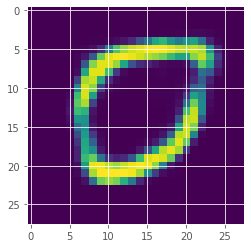

loss: 72.716133  [38400/60000]
KL_loss: 3.506388, recons_loss: 69.209747


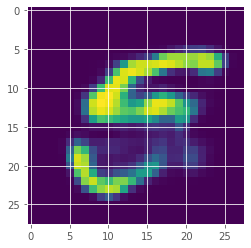

loss: 79.066566  [51200/60000]
KL_loss: 3.812132, recons_loss: 75.254433


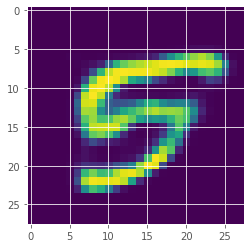

====> Average Train loss: 76.7048
====> Average Test loss: 75.9124
Validation loss decreased (76.588648 --> 75.912405).  Saving model ...
Epoch 13
-------------------------------
loss: 75.508202  [    0/60000]
KL_loss: 3.568845, recons_loss: 71.939362


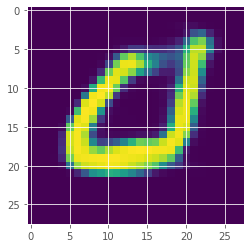

loss: 78.948944  [12800/60000]
KL_loss: 3.978265, recons_loss: 74.970688


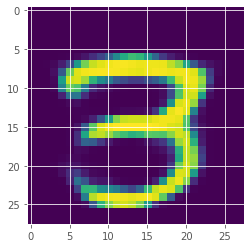

loss: 78.578850  [25600/60000]
KL_loss: 4.122587, recons_loss: 74.456261


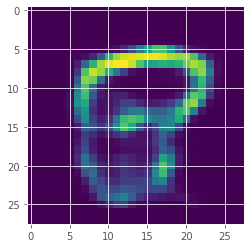

loss: 77.132675  [38400/60000]
KL_loss: 3.672090, recons_loss: 73.460579


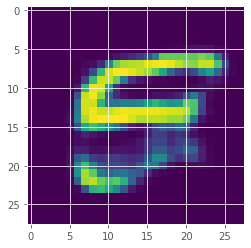

loss: 76.483490  [51200/60000]
KL_loss: 3.848443, recons_loss: 72.635048


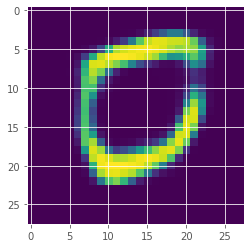

====> Average Train loss: 76.3235
====> Average Test loss: 75.7497
Validation loss decreased (75.912405 --> 75.749710).  Saving model ...
Epoch 14
-------------------------------
loss: 77.777138  [    0/60000]
KL_loss: 3.757117, recons_loss: 74.020012


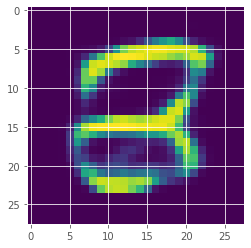

loss: 77.747879  [12800/60000]
KL_loss: 3.941331, recons_loss: 73.806541


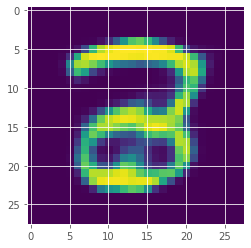

loss: 74.350533  [25600/60000]
KL_loss: 3.978173, recons_loss: 70.372337


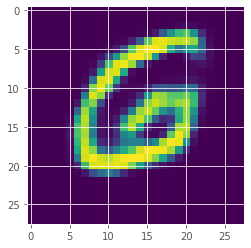

loss: 75.438271  [38400/60000]
KL_loss: 3.972538, recons_loss: 71.465736


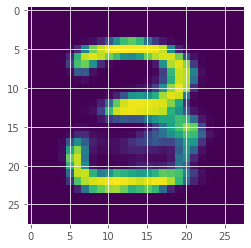

loss: 76.479874  [51200/60000]
KL_loss: 4.033601, recons_loss: 72.446281


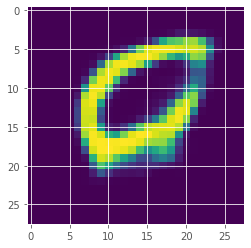

====> Average Train loss: 76.1871
====> Average Test loss: 75.4220
Validation loss decreased (75.749710 --> 75.422019).  Saving model ...
Epoch 15
-------------------------------
loss: 75.241104  [    0/60000]
KL_loss: 4.061933, recons_loss: 71.179169


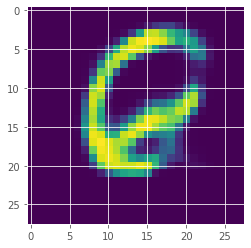

loss: 77.418343  [12800/60000]
KL_loss: 4.169701, recons_loss: 73.248627


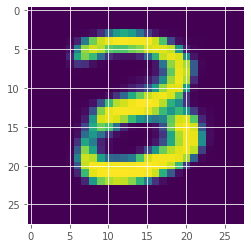

loss: 76.302681  [25600/60000]
KL_loss: 4.052122, recons_loss: 72.250565


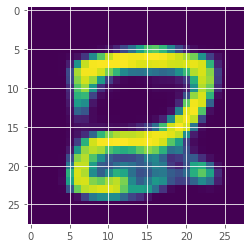

loss: 78.147614  [38400/60000]
KL_loss: 4.096691, recons_loss: 74.050919


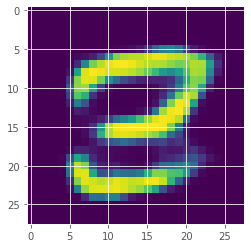

loss: 74.454536  [51200/60000]
KL_loss: 3.961240, recons_loss: 70.493294


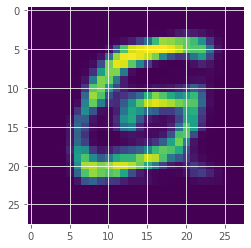

====> Average Train loss: 76.2306
====> Average Test loss: 75.3693
Validation loss decreased (75.422019 --> 75.369310).  Saving model ...
Epoch 16
-------------------------------
loss: 75.102608  [    0/60000]
KL_loss: 4.139263, recons_loss: 70.963333


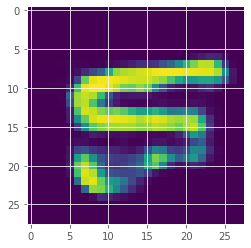

loss: 76.338913  [12800/60000]
KL_loss: 4.450286, recons_loss: 71.888634


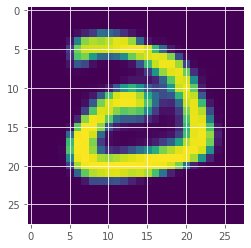

loss: 77.692101  [25600/60000]
KL_loss: 4.021669, recons_loss: 73.670418


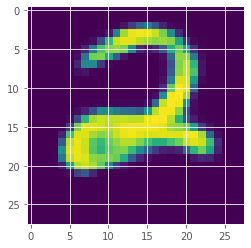

loss: 74.789688  [38400/60000]
KL_loss: 4.006827, recons_loss: 70.782860


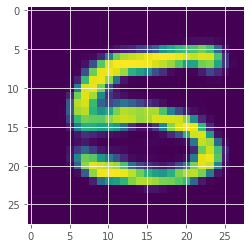

loss: 76.282768  [51200/60000]
KL_loss: 3.946848, recons_loss: 72.335922


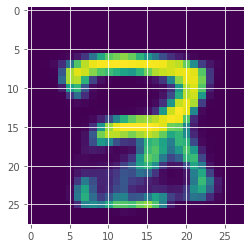

====> Average Train loss: 75.6031
====> Average Test loss: 74.8237
Validation loss decreased (75.369310 --> 74.823746).  Saving model ...
Epoch 17
-------------------------------
loss: 74.409584  [    0/60000]
KL_loss: 3.943892, recons_loss: 70.465691


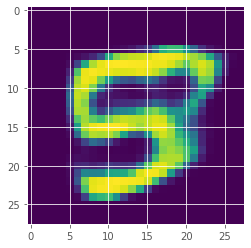

loss: 77.866127  [12800/60000]
KL_loss: 4.505358, recons_loss: 73.360771


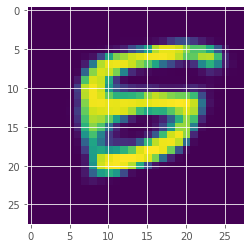

loss: 75.179222  [25600/60000]
KL_loss: 4.158936, recons_loss: 71.020294


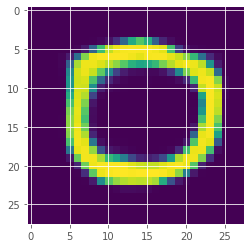

loss: 75.457993  [38400/60000]
KL_loss: 4.098301, recons_loss: 71.359703


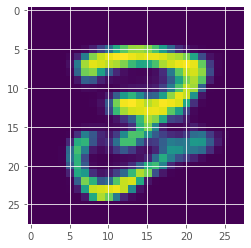

loss: 73.520264  [51200/60000]
KL_loss: 3.850028, recons_loss: 69.670219


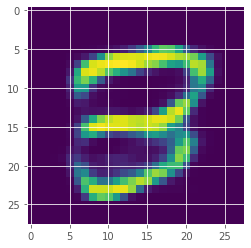

====> Average Train loss: 75.9408
====> Average Test loss: 74.7400
Validation loss decreased (74.823746 --> 74.740045).  Saving model ...
Epoch 18
-------------------------------
loss: 76.331284  [    0/60000]
KL_loss: 3.965156, recons_loss: 72.366135


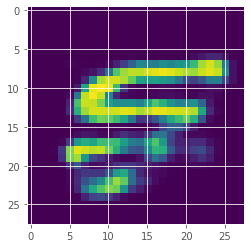

loss: 79.599144  [12800/60000]
KL_loss: 4.464013, recons_loss: 75.135155


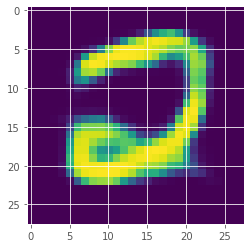

loss: 70.761673  [25600/60000]
KL_loss: 3.992599, recons_loss: 66.769089


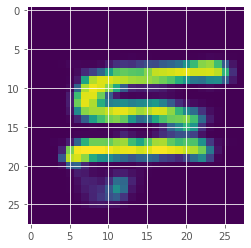

loss: 74.082603  [38400/60000]
KL_loss: 4.309537, recons_loss: 69.773071


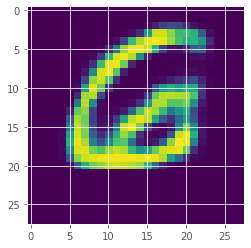

loss: 78.236847  [51200/60000]
KL_loss: 4.400483, recons_loss: 73.836365


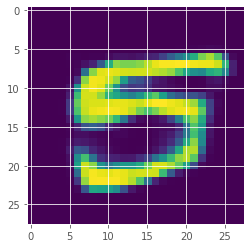

====> Average Train loss: 75.1967
====> Average Test loss: 74.4339
Validation loss decreased (74.740045 --> 74.433893).  Saving model ...
Epoch 19
-------------------------------
loss: 72.009209  [    0/60000]
KL_loss: 4.026581, recons_loss: 67.982635


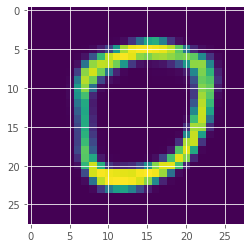

loss: 73.333740  [12800/60000]
KL_loss: 4.040334, recons_loss: 69.293388


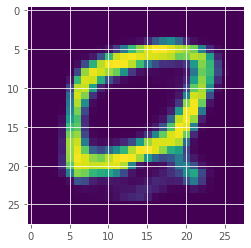

loss: 75.640793  [25600/60000]
KL_loss: 4.424450, recons_loss: 71.216339


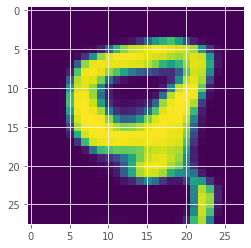

loss: 76.601685  [38400/60000]
KL_loss: 4.190850, recons_loss: 72.410828


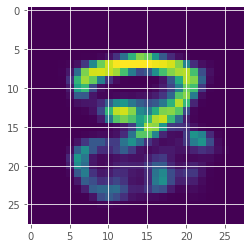

loss: 73.961357  [51200/60000]
KL_loss: 4.224025, recons_loss: 69.737328


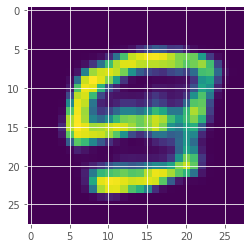

====> Average Train loss: 75.6608
====> Average Test loss: 74.4384
EarlyStopping counter: 1 out of 5
Epoch 20
-------------------------------
loss: 73.956161  [    0/60000]
KL_loss: 4.130429, recons_loss: 69.825737


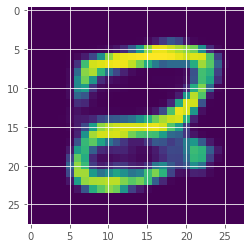

loss: 73.723976  [12800/60000]
KL_loss: 4.220479, recons_loss: 69.503494


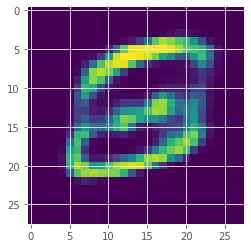

loss: 77.290123  [25600/60000]
KL_loss: 4.189881, recons_loss: 73.100235


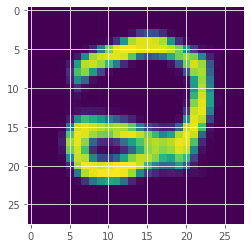

loss: 75.552719  [38400/60000]
KL_loss: 4.240797, recons_loss: 71.311920


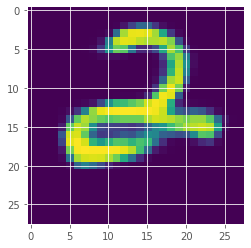

loss: 75.926254  [51200/60000]
KL_loss: 4.341578, recons_loss: 71.584671


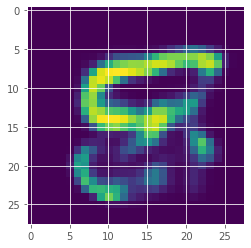

====> Average Train loss: 74.8281
====> Average Test loss: 74.3319
Validation loss decreased (74.433893 --> 74.331887).  Saving model ...
Epoch 21
-------------------------------
loss: 76.213852  [    0/60000]
KL_loss: 4.347238, recons_loss: 71.866615


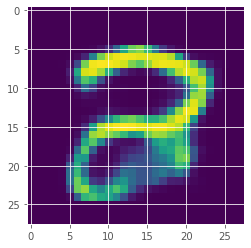

loss: 76.222206  [12800/60000]
KL_loss: 4.287899, recons_loss: 71.934303


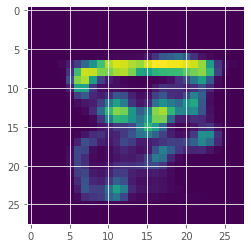

loss: 75.775574  [25600/60000]
KL_loss: 4.288414, recons_loss: 71.487160


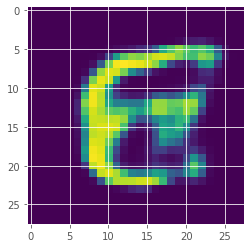

loss: 74.961609  [38400/60000]
KL_loss: 4.067669, recons_loss: 70.893944


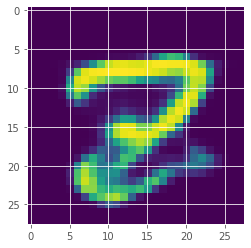

loss: 73.504852  [51200/60000]
KL_loss: 4.263996, recons_loss: 69.240852


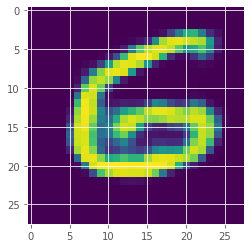

====> Average Train loss: 75.3626
====> Average Test loss: 74.6321
EarlyStopping counter: 1 out of 5
Epoch 22
-------------------------------
loss: 78.817215  [    0/60000]
KL_loss: 4.634998, recons_loss: 74.182220


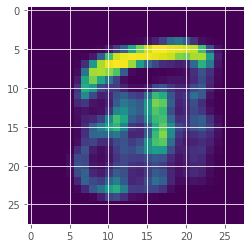

loss: 72.597351  [12800/60000]
KL_loss: 3.938118, recons_loss: 68.659233


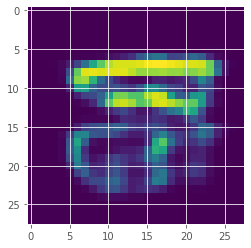

loss: 78.399147  [25600/60000]
KL_loss: 4.649574, recons_loss: 73.749580


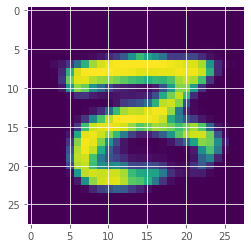

loss: 76.274963  [38400/60000]
KL_loss: 4.329425, recons_loss: 71.945541


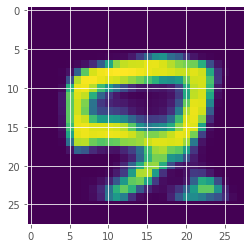

loss: 75.323433  [51200/60000]
KL_loss: 4.187224, recons_loss: 71.136208


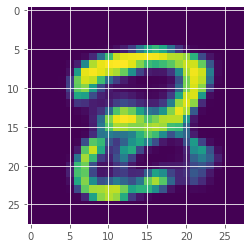

====> Average Train loss: 74.6616
====> Average Test loss: 74.7470
EarlyStopping counter: 2 out of 5
Epoch 23
-------------------------------
loss: 74.683968  [    0/60000]
KL_loss: 4.252614, recons_loss: 70.431374


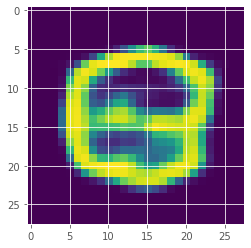

loss: 76.098267  [12800/60000]
KL_loss: 4.292234, recons_loss: 71.806015


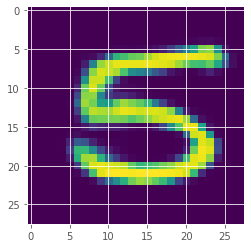

loss: 73.032234  [25600/60000]
KL_loss: 4.594350, recons_loss: 68.437881


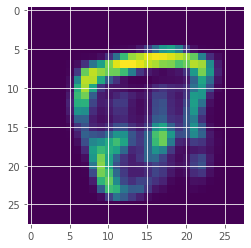

loss: 77.400368  [38400/60000]
KL_loss: 4.790616, recons_loss: 72.609764


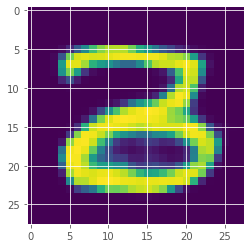

loss: 73.588150  [51200/60000]
KL_loss: 4.269137, recons_loss: 69.319023


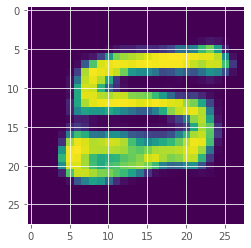

====> Average Train loss: 75.2064
====> Average Test loss: 74.4393
EarlyStopping counter: 3 out of 5
Epoch 24
-------------------------------
loss: 76.447990  [    0/60000]
KL_loss: 4.313111, recons_loss: 72.134888


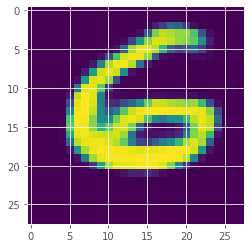

loss: 75.852432  [12800/60000]
KL_loss: 4.269016, recons_loss: 71.583397


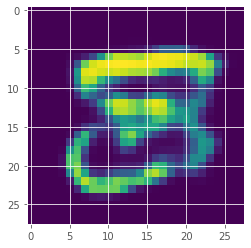

loss: 74.717430  [25600/60000]
KL_loss: 4.393019, recons_loss: 70.324402


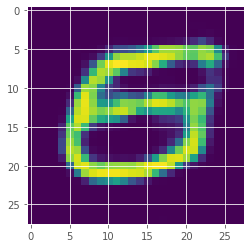

loss: 75.091270  [38400/60000]
KL_loss: 4.144444, recons_loss: 70.946823


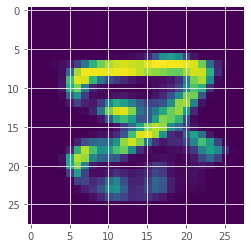

loss: 74.417023  [51200/60000]
KL_loss: 4.201805, recons_loss: 70.215210


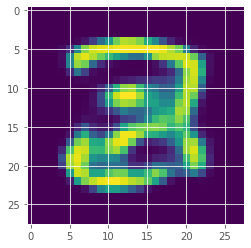

====> Average Train loss: 74.3691
====> Average Test loss: 73.8295
Validation loss decreased (74.331887 --> 73.829535).  Saving model ...
Epoch 25
-------------------------------
loss: 74.473579  [    0/60000]
KL_loss: 4.129779, recons_loss: 70.343803


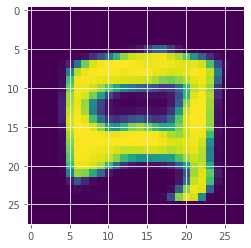

loss: 76.777855  [12800/60000]
KL_loss: 4.483653, recons_loss: 72.294220


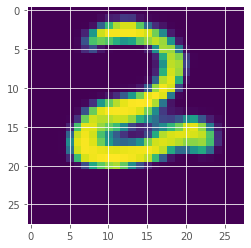

loss: 80.115234  [25600/60000]
KL_loss: 4.832777, recons_loss: 75.282455


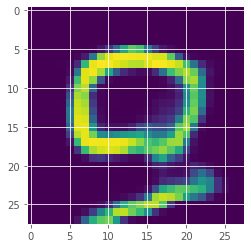

loss: 76.088333  [38400/60000]
KL_loss: 4.550080, recons_loss: 71.538254


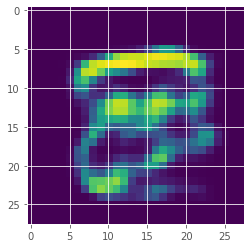

loss: 73.748512  [51200/60000]
KL_loss: 4.100046, recons_loss: 69.648460


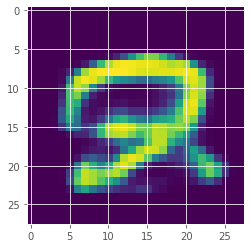

====> Average Train loss: 74.9590
====> Average Test loss: 73.9770
EarlyStopping counter: 1 out of 5
Epoch 26
-------------------------------
loss: 74.828728  [    0/60000]
KL_loss: 4.619314, recons_loss: 70.209412


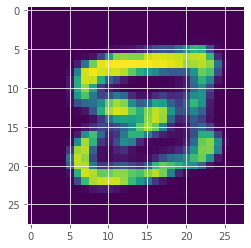

loss: 75.364098  [12800/60000]
KL_loss: 4.214279, recons_loss: 71.149826


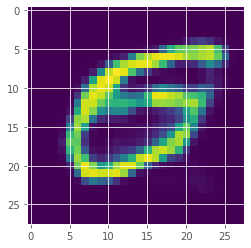

loss: 75.878464  [25600/60000]
KL_loss: 4.503984, recons_loss: 71.374474


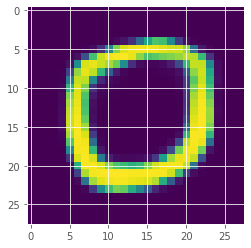

loss: 73.148087  [38400/60000]
KL_loss: 4.249880, recons_loss: 68.898209


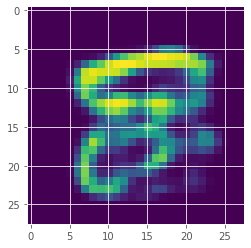

loss: 75.532059  [51200/60000]
KL_loss: 4.600437, recons_loss: 70.931610


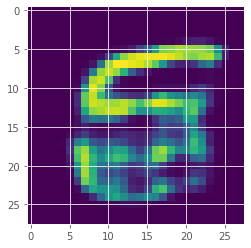

====> Average Train loss: 74.3558
====> Average Test loss: 73.5604
Validation loss decreased (73.829535 --> 73.560393).  Saving model ...
Epoch 27
-------------------------------
loss: 72.343254  [    0/60000]
KL_loss: 4.284028, recons_loss: 68.059242


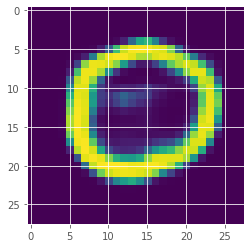

loss: 73.191078  [12800/60000]
KL_loss: 4.095780, recons_loss: 69.095291


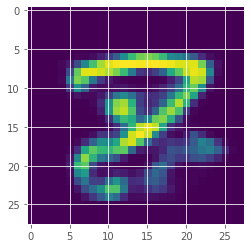

loss: 72.624664  [25600/60000]
KL_loss: 4.156569, recons_loss: 68.468079


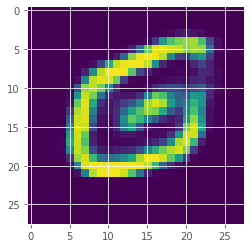

loss: 73.134590  [38400/60000]
KL_loss: 4.053148, recons_loss: 69.081444


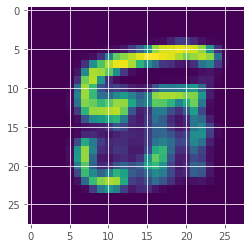

loss: 73.490921  [51200/60000]
KL_loss: 4.359974, recons_loss: 69.130943


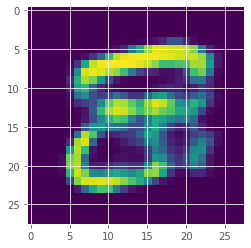

====> Average Train loss: 73.9471
====> Average Test loss: 73.4367
Validation loss decreased (73.560393 --> 73.436702).  Saving model ...
Epoch 28
-------------------------------
loss: 72.349678  [    0/60000]
KL_loss: 4.041831, recons_loss: 68.307846


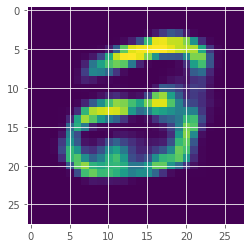

loss: 73.068916  [12800/60000]
KL_loss: 3.888950, recons_loss: 69.179962


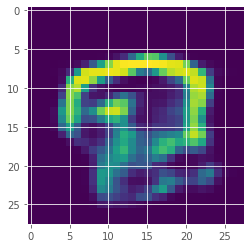

loss: 77.166466  [25600/60000]
KL_loss: 4.312137, recons_loss: 72.854332


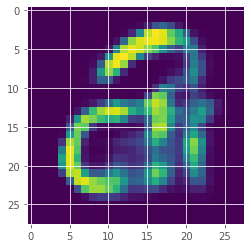

loss: 74.084351  [38400/60000]
KL_loss: 4.167805, recons_loss: 69.916534


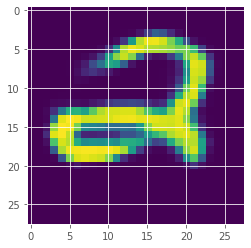

loss: 72.672409  [51200/60000]
KL_loss: 4.141776, recons_loss: 68.530632


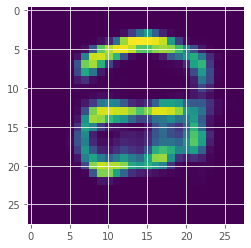

====> Average Train loss: 74.5393
====> Average Test loss: 73.9591
EarlyStopping counter: 1 out of 5
Epoch 29
-------------------------------
loss: 74.927689  [    0/60000]
KL_loss: 4.252510, recons_loss: 70.675171


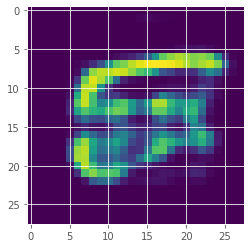

loss: 75.439766  [12800/60000]
KL_loss: 4.552384, recons_loss: 70.887398


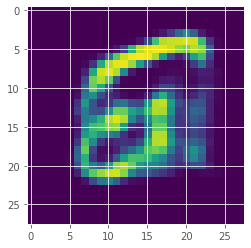

loss: 72.477394  [25600/60000]
KL_loss: 4.326591, recons_loss: 68.150810


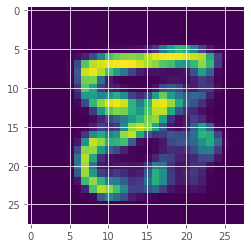

loss: 75.321640  [38400/60000]
KL_loss: 4.330866, recons_loss: 70.990776


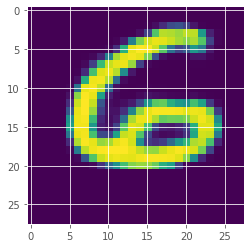

loss: 75.653374  [51200/60000]
KL_loss: 4.263619, recons_loss: 71.389755


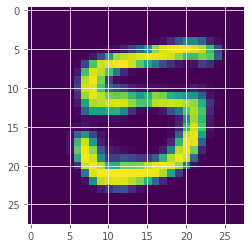

====> Average Train loss: 74.0478
====> Average Test loss: 74.2473
EarlyStopping counter: 2 out of 5
Epoch 30
-------------------------------
loss: 76.121445  [    0/60000]
KL_loss: 4.347269, recons_loss: 71.774178


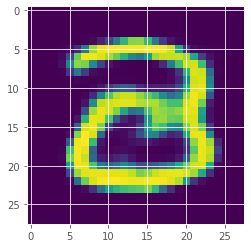

loss: 75.151169  [12800/60000]
KL_loss: 4.495906, recons_loss: 70.655266


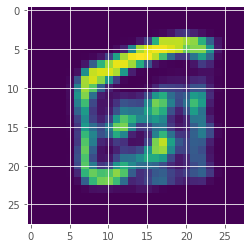

loss: 74.310211  [25600/60000]
KL_loss: 4.371006, recons_loss: 69.939209


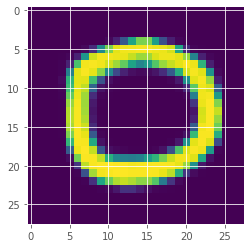

loss: 73.532562  [38400/60000]
KL_loss: 4.210070, recons_loss: 69.322487


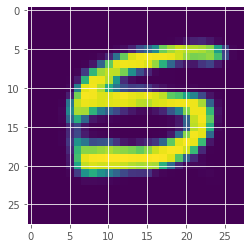

loss: 71.889069  [51200/60000]
KL_loss: 3.936618, recons_loss: 67.952469


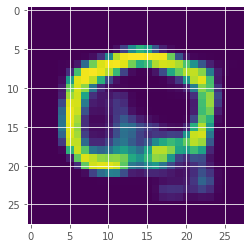

====> Average Train loss: 73.7397
====> Average Test loss: 73.2872
Validation loss decreased (73.436702 --> 73.287184).  Saving model ...
Epoch 31
-------------------------------
loss: 74.515053  [    0/60000]
KL_loss: 4.466972, recons_loss: 70.048096


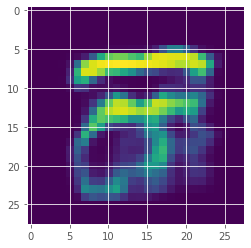

loss: 73.570412  [12800/60000]
KL_loss: 4.491096, recons_loss: 69.079308


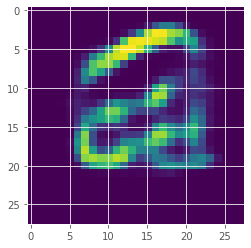

loss: 73.640549  [25600/60000]
KL_loss: 4.184203, recons_loss: 69.456337


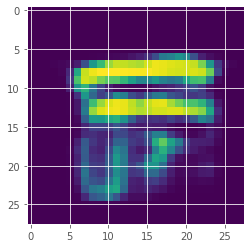

loss: 73.035278  [38400/60000]
KL_loss: 4.179308, recons_loss: 68.855972


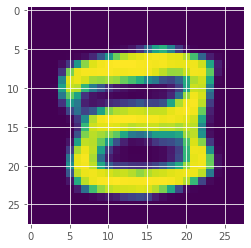

loss: 74.393738  [51200/60000]
KL_loss: 4.416497, recons_loss: 69.977257


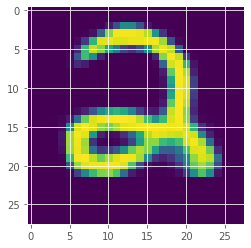

====> Average Train loss: 74.0114
====> Average Test loss: 73.9036
EarlyStopping counter: 1 out of 5
Epoch 32
-------------------------------
loss: 72.869370  [    0/60000]
KL_loss: 4.393590, recons_loss: 68.475761


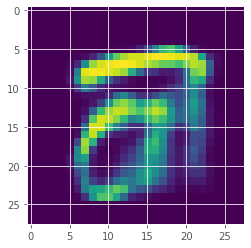

loss: 75.315460  [12800/60000]
KL_loss: 4.558778, recons_loss: 70.756668


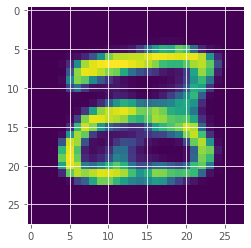

loss: 71.532127  [25600/60000]
KL_loss: 3.975147, recons_loss: 67.556976


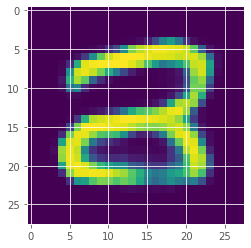

loss: 71.928818  [38400/60000]
KL_loss: 4.305386, recons_loss: 67.623436


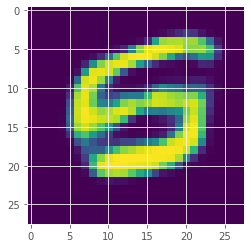

loss: 71.657890  [51200/60000]
KL_loss: 3.965724, recons_loss: 67.692169


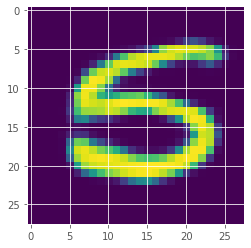

====> Average Train loss: 73.6089
====> Average Test loss: 73.0833
Validation loss decreased (73.287184 --> 73.083253).  Saving model ...
Epoch 33
-------------------------------
loss: 72.952744  [    0/60000]
KL_loss: 3.981256, recons_loss: 68.971489


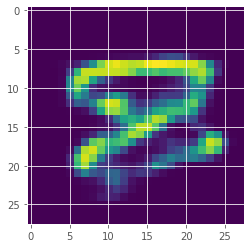

loss: 72.796860  [12800/60000]
KL_loss: 4.379838, recons_loss: 68.417023


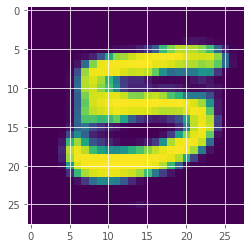

loss: 70.614174  [25600/60000]
KL_loss: 4.239271, recons_loss: 66.374901


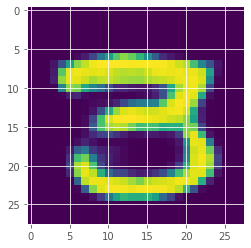

loss: 74.160942  [38400/60000]
KL_loss: 4.212974, recons_loss: 69.947960


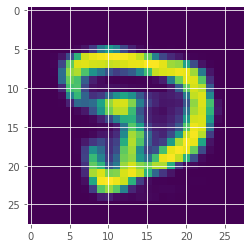

loss: 76.211639  [51200/60000]
KL_loss: 4.676220, recons_loss: 71.535431


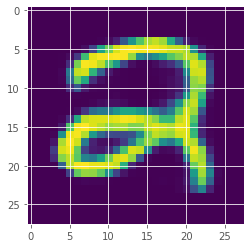

====> Average Train loss: 73.5166
====> Average Test loss: 73.0564
Validation loss decreased (73.083253 --> 73.056439).  Saving model ...
Epoch 34
-------------------------------
loss: 73.142029  [    0/60000]
KL_loss: 4.297113, recons_loss: 68.844917


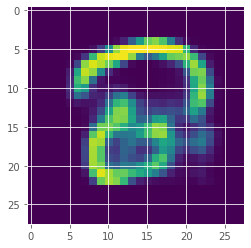

loss: 74.585625  [12800/60000]
KL_loss: 4.325725, recons_loss: 70.259903


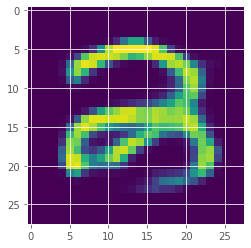

loss: 74.838913  [25600/60000]
KL_loss: 4.332533, recons_loss: 70.506378


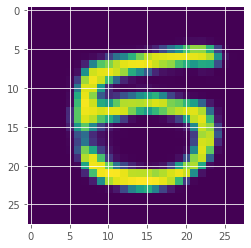

loss: 74.310257  [38400/60000]
KL_loss: 4.317389, recons_loss: 69.992867


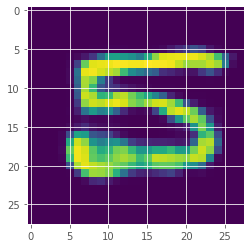

loss: 72.248993  [51200/60000]
KL_loss: 4.000080, recons_loss: 68.248909


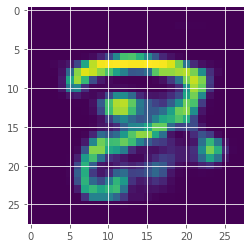

====> Average Train loss: 73.9921
====> Average Test loss: 73.2207
EarlyStopping counter: 1 out of 5
Epoch 35
-------------------------------
loss: 72.836418  [    0/60000]
KL_loss: 4.135765, recons_loss: 68.700661


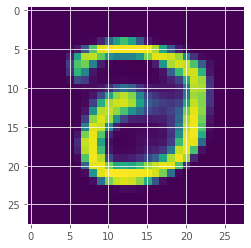

loss: 71.451439  [12800/60000]
KL_loss: 4.097371, recons_loss: 67.354065


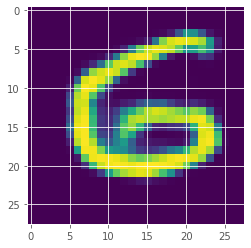

loss: 75.333672  [25600/60000]
KL_loss: 4.786938, recons_loss: 70.546730


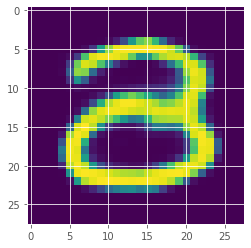

loss: 73.712120  [38400/60000]
KL_loss: 4.324790, recons_loss: 69.387337


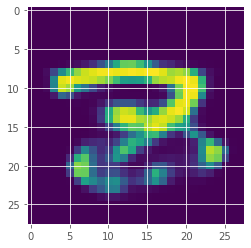

loss: 75.967567  [51200/60000]
KL_loss: 4.410842, recons_loss: 71.556732


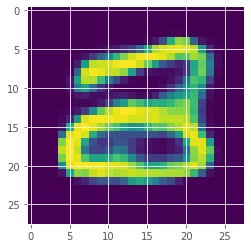

====> Average Train loss: 73.4195
====> Average Test loss: 72.9543
Validation loss decreased (73.056439 --> 72.954278).  Saving model ...
Epoch 36
-------------------------------
loss: 72.439606  [    0/60000]
KL_loss: 4.145531, recons_loss: 68.294075


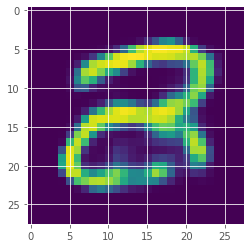

loss: 69.437386  [12800/60000]
KL_loss: 4.012515, recons_loss: 65.424889


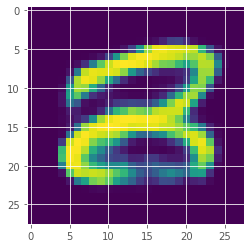

loss: 75.848351  [25600/60000]
KL_loss: 4.313426, recons_loss: 71.534943


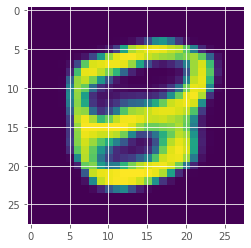

loss: 77.019920  [38400/60000]
KL_loss: 4.476341, recons_loss: 72.543587


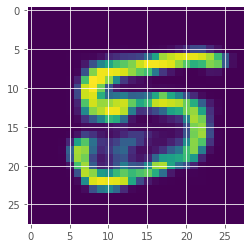

loss: 77.679359  [51200/60000]
KL_loss: 4.417448, recons_loss: 73.261887


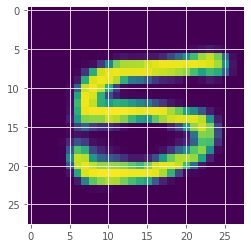

====> Average Train loss: 73.9306
====> Average Test loss: 73.3495
EarlyStopping counter: 1 out of 5
Epoch 37
-------------------------------
loss: 75.047333  [    0/60000]
KL_loss: 4.175586, recons_loss: 70.871742


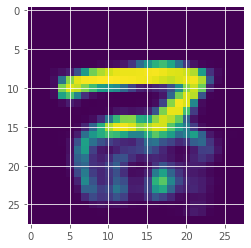

loss: 76.852760  [12800/60000]
KL_loss: 4.519778, recons_loss: 72.332993


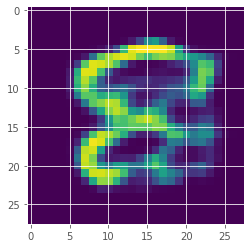

loss: 70.804298  [25600/60000]
KL_loss: 3.963372, recons_loss: 66.840927


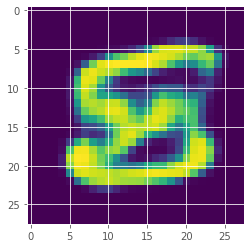

loss: 76.325943  [38400/60000]
KL_loss: 4.114458, recons_loss: 72.211487


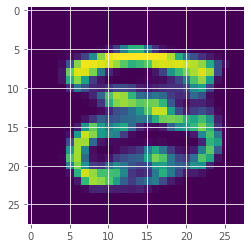

loss: 73.226791  [51200/60000]
KL_loss: 4.173236, recons_loss: 69.053558


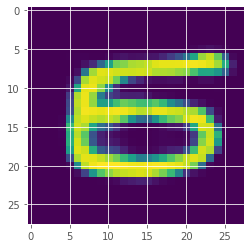

====> Average Train loss: 73.1916
====> Average Test loss: 73.1297
EarlyStopping counter: 2 out of 5
Epoch 38
-------------------------------
loss: 73.093933  [    0/60000]
KL_loss: 3.954167, recons_loss: 69.139763


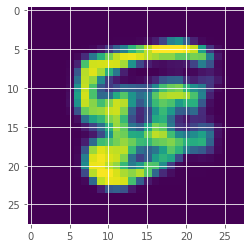

loss: 74.822647  [12800/60000]
KL_loss: 4.647565, recons_loss: 70.175079


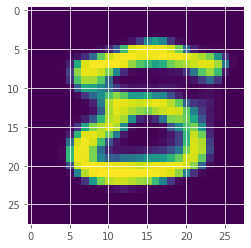

loss: 72.943420  [25600/60000]
KL_loss: 4.544272, recons_loss: 68.399132


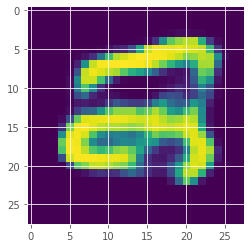

loss: 74.128593  [38400/60000]
KL_loss: 4.105549, recons_loss: 70.023064


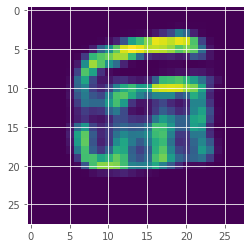

loss: 76.112190  [51200/60000]
KL_loss: 4.196205, recons_loss: 71.915970


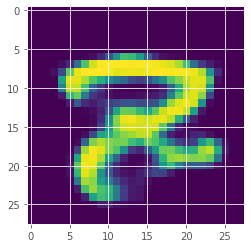

====> Average Train loss: 73.1248
====> Average Test loss: 72.8293
Validation loss decreased (72.954278 --> 72.829286).  Saving model ...
Epoch 39
-------------------------------
loss: 71.121437  [    0/60000]
KL_loss: 4.139839, recons_loss: 66.981598


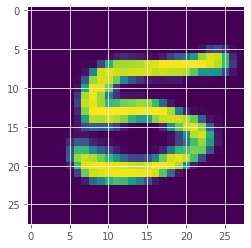

loss: 70.768745  [12800/60000]
KL_loss: 4.267060, recons_loss: 66.501678


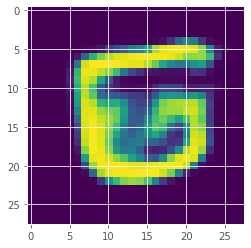

loss: 71.637947  [25600/60000]
KL_loss: 4.308509, recons_loss: 67.329430


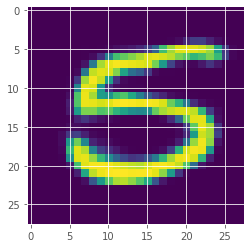

loss: 74.090759  [38400/60000]
KL_loss: 4.681319, recons_loss: 69.409447


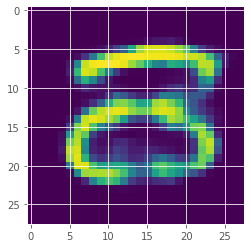

loss: 74.444946  [51200/60000]
KL_loss: 4.177049, recons_loss: 70.267906


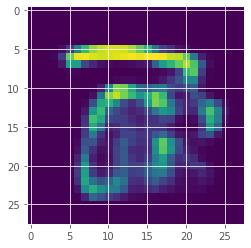

====> Average Train loss: 73.3920
====> Average Test loss: 72.7612
Validation loss decreased (72.829286 --> 72.761166).  Saving model ...
Epoch 40
-------------------------------
loss: 74.155045  [    0/60000]
KL_loss: 4.502809, recons_loss: 69.652222


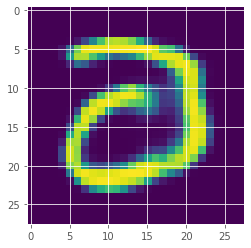

loss: 73.332649  [12800/60000]
KL_loss: 4.358947, recons_loss: 68.973709


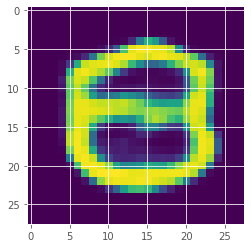

loss: 69.937424  [25600/60000]
KL_loss: 4.140147, recons_loss: 65.797272


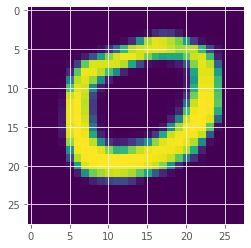

loss: 79.781219  [38400/60000]
KL_loss: 4.387567, recons_loss: 75.393654


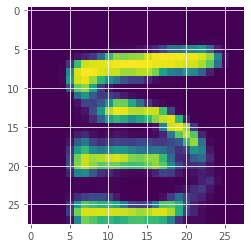

loss: 75.224266  [51200/60000]
KL_loss: 4.315866, recons_loss: 70.908394


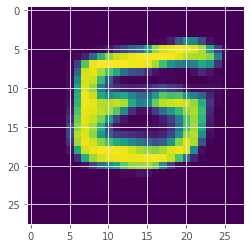

====> Average Train loss: 74.1004
====> Average Test loss: 73.5527
EarlyStopping counter: 1 out of 5
Epoch 41
-------------------------------
loss: 73.213455  [    0/60000]
KL_loss: 4.186002, recons_loss: 69.027451


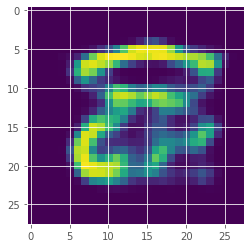

loss: 78.175636  [12800/60000]
KL_loss: 4.229443, recons_loss: 73.946190


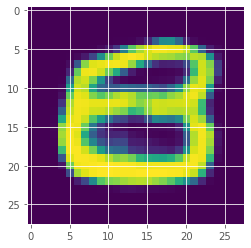

loss: 75.525627  [25600/60000]
KL_loss: 4.386453, recons_loss: 71.139175


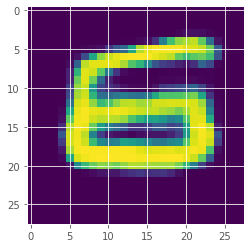

loss: 70.799782  [38400/60000]
KL_loss: 4.127249, recons_loss: 66.672546


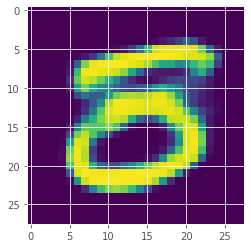

loss: 73.035828  [51200/60000]
KL_loss: 4.217212, recons_loss: 68.818626


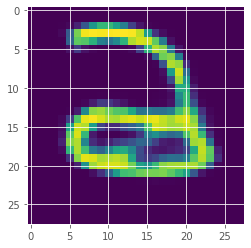

====> Average Train loss: 73.4602
====> Average Test loss: 72.9464
EarlyStopping counter: 2 out of 5
Epoch 42
-------------------------------
loss: 71.849838  [    0/60000]
KL_loss: 4.219114, recons_loss: 67.630722


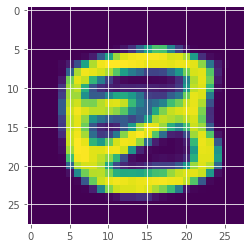

loss: 74.279549  [12800/60000]
KL_loss: 4.203621, recons_loss: 70.075935


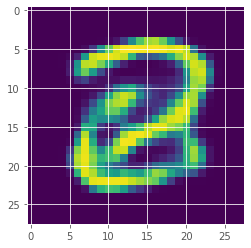

loss: 70.607056  [25600/60000]
KL_loss: 4.265368, recons_loss: 66.341698


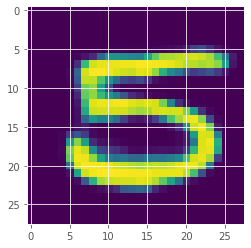

loss: 72.359505  [38400/60000]
KL_loss: 4.198654, recons_loss: 68.160858


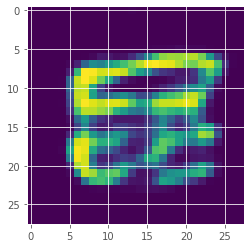

loss: 72.580956  [51200/60000]
KL_loss: 4.336586, recons_loss: 68.244354


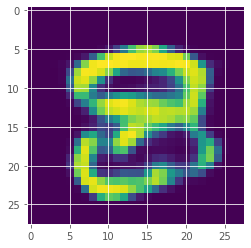

====> Average Train loss: 73.0378
====> Average Test loss: 72.6856
Validation loss decreased (72.761166 --> 72.685567).  Saving model ...
Epoch 43
-------------------------------
loss: 71.663406  [    0/60000]
KL_loss: 4.020316, recons_loss: 67.643089


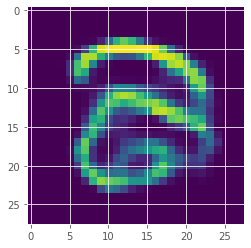

loss: 72.379364  [12800/60000]
KL_loss: 4.042393, recons_loss: 68.336967


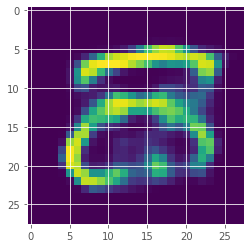

loss: 76.660446  [25600/60000]
KL_loss: 4.646504, recons_loss: 72.013954


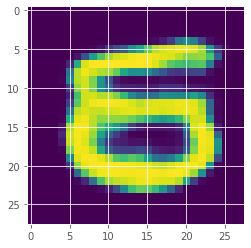

loss: 71.744492  [38400/60000]
KL_loss: 4.085166, recons_loss: 67.659317


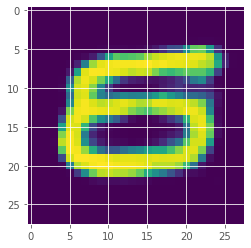

loss: 77.339569  [51200/60000]
KL_loss: 4.511211, recons_loss: 72.828354


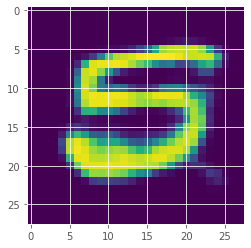

====> Average Train loss: 72.9662
====> Average Test loss: 72.4442
Validation loss decreased (72.685567 --> 72.444186).  Saving model ...
Epoch 44
-------------------------------
loss: 73.337753  [    0/60000]
KL_loss: 4.387295, recons_loss: 68.950455


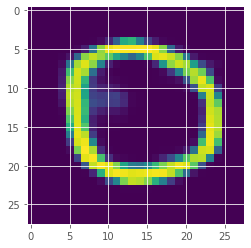

loss: 74.201607  [12800/60000]
KL_loss: 3.994144, recons_loss: 70.207466


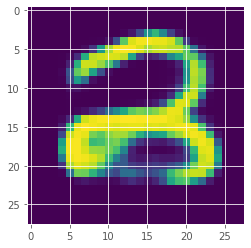

loss: 69.695969  [25600/60000]
KL_loss: 4.181932, recons_loss: 65.514038


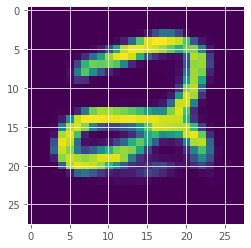

loss: 72.849342  [38400/60000]
KL_loss: 4.193168, recons_loss: 68.656166


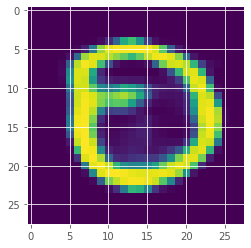

loss: 70.801857  [51200/60000]
KL_loss: 4.199604, recons_loss: 66.602257


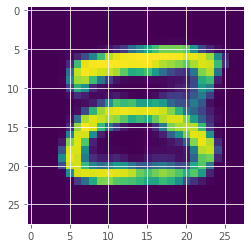

====> Average Train loss: 73.1089
====> Average Test loss: 72.5440
EarlyStopping counter: 1 out of 5
Epoch 45
-------------------------------
loss: 72.698990  [    0/60000]
KL_loss: 4.114734, recons_loss: 68.584244


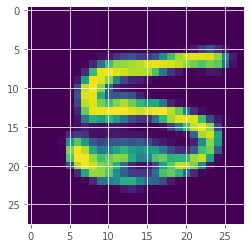

loss: 71.221024  [12800/60000]
KL_loss: 4.361841, recons_loss: 66.859184


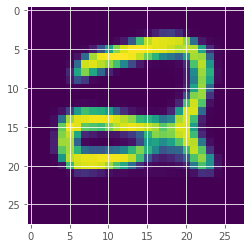

loss: 74.943390  [25600/60000]
KL_loss: 4.056110, recons_loss: 70.887306


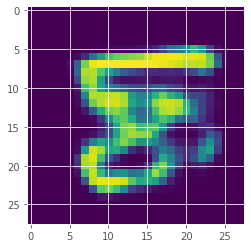

loss: 73.216682  [38400/60000]
KL_loss: 4.005494, recons_loss: 69.211182


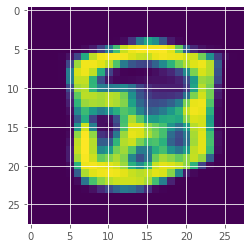

loss: 72.947647  [51200/60000]
KL_loss: 4.205863, recons_loss: 68.741791


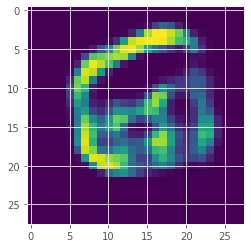

====> Average Train loss: 72.7454
====> Average Test loss: 72.3318
Validation loss decreased (72.444186 --> 72.331760).  Saving model ...
Epoch 46
-------------------------------
loss: 71.232620  [    0/60000]
KL_loss: 4.185257, recons_loss: 67.047356


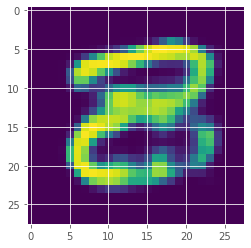

loss: 71.599487  [12800/60000]
KL_loss: 4.313289, recons_loss: 67.286194


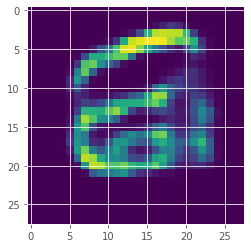

loss: 73.010040  [25600/60000]
KL_loss: 4.288522, recons_loss: 68.721527


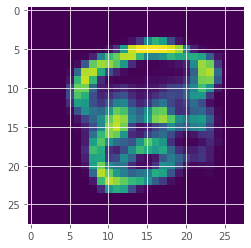

loss: 73.512810  [38400/60000]
KL_loss: 4.158991, recons_loss: 69.353836


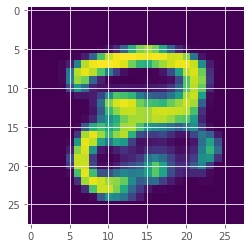

loss: 72.726799  [51200/60000]
KL_loss: 4.093803, recons_loss: 68.632996


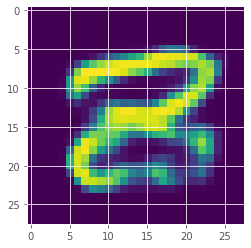

====> Average Train loss: 72.7030
====> Average Test loss: 72.4572
EarlyStopping counter: 1 out of 5
Epoch 47
-------------------------------
loss: 72.193817  [    0/60000]
KL_loss: 4.259350, recons_loss: 67.934479


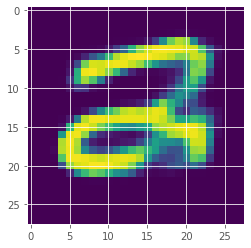

loss: 72.397835  [12800/60000]
KL_loss: 4.136617, recons_loss: 68.261208


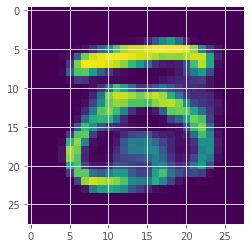

loss: 72.957481  [25600/60000]
KL_loss: 4.201821, recons_loss: 68.755653


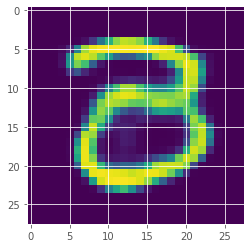

loss: 70.997421  [38400/60000]
KL_loss: 4.088672, recons_loss: 66.908745


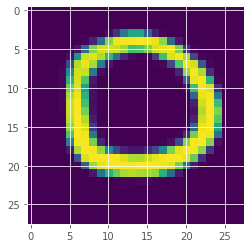

loss: 69.750778  [51200/60000]
KL_loss: 4.137284, recons_loss: 65.613495


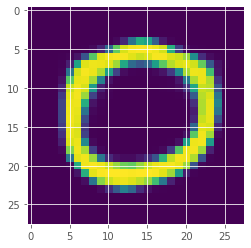

====> Average Train loss: 72.6300
====> Average Test loss: 72.3798
EarlyStopping counter: 2 out of 5
Epoch 48
-------------------------------
loss: 73.089058  [    0/60000]
KL_loss: 4.104771, recons_loss: 68.984283


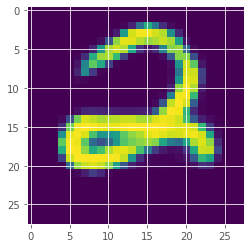

loss: 73.614952  [12800/60000]
KL_loss: 4.218849, recons_loss: 69.396126


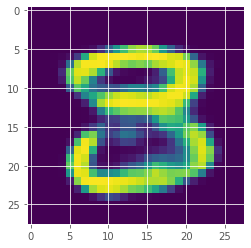

loss: 73.602020  [25600/60000]
KL_loss: 4.200275, recons_loss: 69.401741


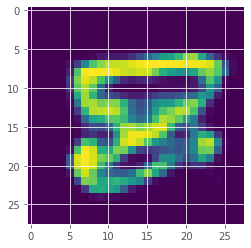

loss: 69.202019  [38400/60000]
KL_loss: 3.904877, recons_loss: 65.297134


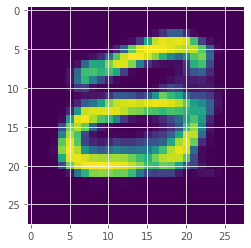

loss: 71.700134  [51200/60000]
KL_loss: 4.392326, recons_loss: 67.307800


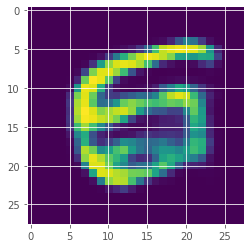

====> Average Train loss: 72.7649
====> Average Test loss: 72.3758
EarlyStopping counter: 3 out of 5
Epoch 49
-------------------------------
loss: 73.936081  [    0/60000]
KL_loss: 4.108824, recons_loss: 69.827263


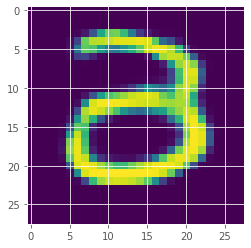

loss: 70.484062  [12800/60000]
KL_loss: 4.260933, recons_loss: 66.223145


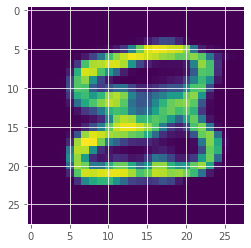

loss: 71.911369  [25600/60000]
KL_loss: 4.300595, recons_loss: 67.610779


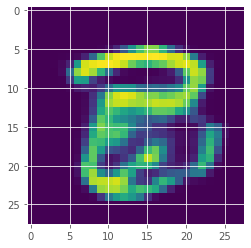

loss: 70.409843  [38400/60000]
KL_loss: 4.080387, recons_loss: 66.329453


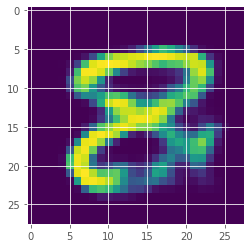

loss: 70.594460  [51200/60000]
KL_loss: 4.157934, recons_loss: 66.436523


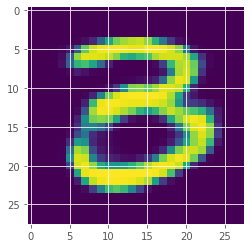

====> Average Train loss: 72.5788
====> Average Test loss: 72.2496
Validation loss decreased (72.331760 --> 72.249621).  Saving model ...
Epoch 50
-------------------------------
loss: 73.463898  [    0/60000]
KL_loss: 4.107917, recons_loss: 69.355965


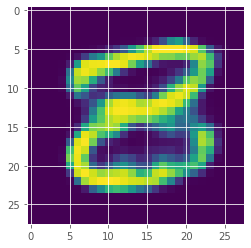

loss: 74.558655  [12800/60000]
KL_loss: 4.271146, recons_loss: 70.287514


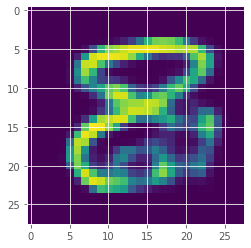

loss: 73.722115  [25600/60000]
KL_loss: 4.193498, recons_loss: 69.528610


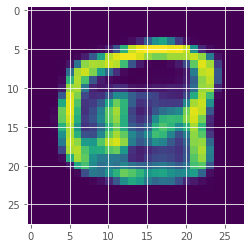

loss: 74.924278  [38400/60000]
KL_loss: 4.512611, recons_loss: 70.411674


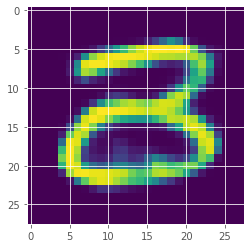

loss: 69.337601  [51200/60000]
KL_loss: 3.993557, recons_loss: 65.344040


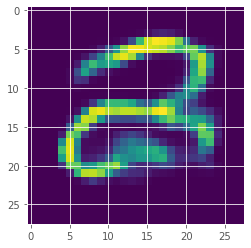

====> Average Train loss: 72.4552
====> Average Test loss: 72.2203
Validation loss decreased (72.249621 --> 72.220262).  Saving model ...
Epoch 51
-------------------------------
loss: 73.511307  [    0/60000]
KL_loss: 4.350250, recons_loss: 69.161049


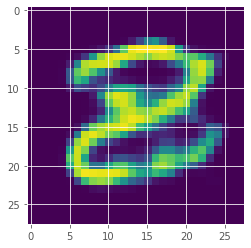

loss: 71.736351  [12800/60000]
KL_loss: 4.122554, recons_loss: 67.613800


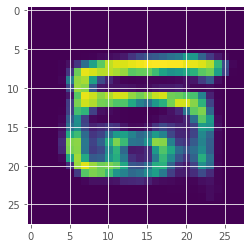

loss: 72.885391  [25600/60000]
KL_loss: 4.471837, recons_loss: 68.413559


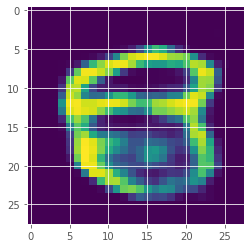

loss: 73.332443  [38400/60000]
KL_loss: 4.224672, recons_loss: 69.107780


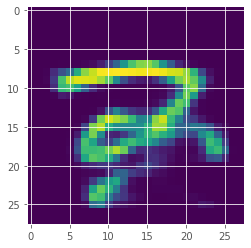

loss: 74.136375  [51200/60000]
KL_loss: 4.036709, recons_loss: 70.099663


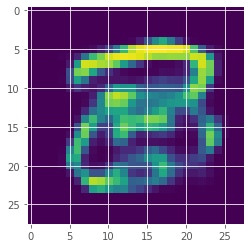

====> Average Train loss: 72.4860
====> Average Test loss: 72.4602
EarlyStopping counter: 1 out of 5
Epoch 52
-------------------------------
loss: 71.869865  [    0/60000]
KL_loss: 4.133135, recons_loss: 67.736748


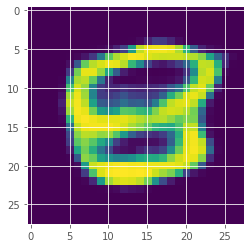

loss: 73.980469  [12800/60000]
KL_loss: 4.589845, recons_loss: 69.390625


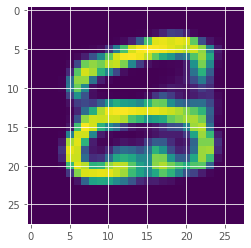

loss: 70.553162  [25600/60000]
KL_loss: 4.169329, recons_loss: 66.383835


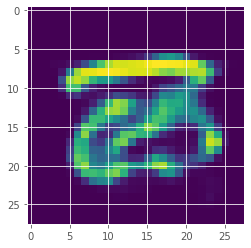

loss: 77.630295  [38400/60000]
KL_loss: 4.273698, recons_loss: 73.356613


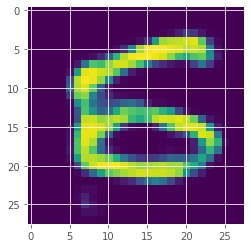

loss: 74.655663  [51200/60000]
KL_loss: 4.399357, recons_loss: 70.256294


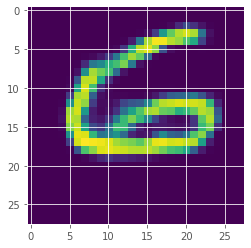

====> Average Train loss: 74.0253
====> Average Test loss: 73.6290
EarlyStopping counter: 2 out of 5
Epoch 53
-------------------------------
loss: 75.715973  [    0/60000]
KL_loss: 4.371389, recons_loss: 71.344582


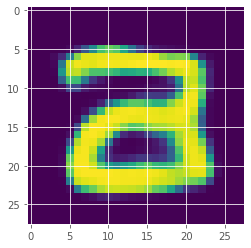

loss: 71.084923  [12800/60000]
KL_loss: 4.465454, recons_loss: 66.619484


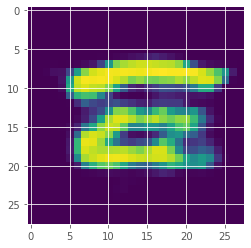

loss: 72.234612  [25600/60000]
KL_loss: 4.070361, recons_loss: 68.164253


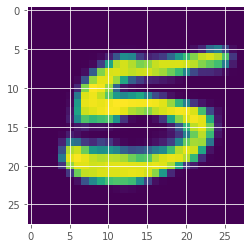

loss: 70.570839  [38400/60000]
KL_loss: 4.323534, recons_loss: 66.247314


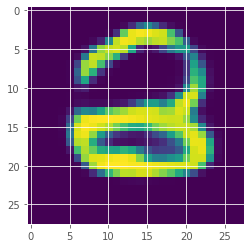

loss: 75.373901  [51200/60000]
KL_loss: 4.354180, recons_loss: 71.019714


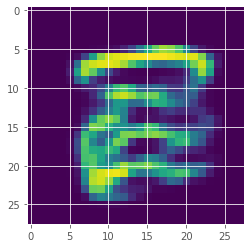

====> Average Train loss: 73.4307
====> Average Test loss: 72.7403
EarlyStopping counter: 3 out of 5
Epoch 54
-------------------------------
loss: 74.088264  [    0/60000]
KL_loss: 4.184796, recons_loss: 69.903473


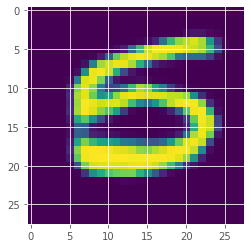

loss: 72.480492  [12800/60000]
KL_loss: 4.456726, recons_loss: 68.023781


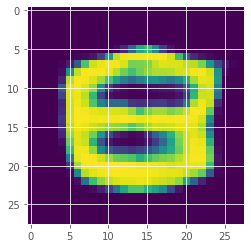

loss: 71.712387  [25600/60000]
KL_loss: 4.005222, recons_loss: 67.707153


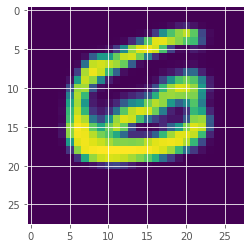

loss: 73.062424  [38400/60000]
KL_loss: 3.950125, recons_loss: 69.112320


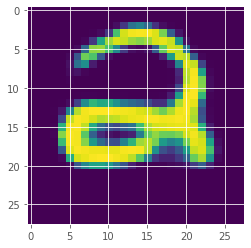

loss: 74.843048  [51200/60000]
KL_loss: 4.339398, recons_loss: 70.503654


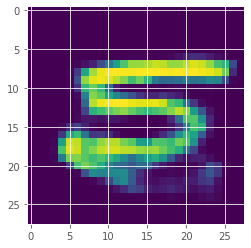

====> Average Train loss: 72.8166
====> Average Test loss: 72.4945
EarlyStopping counter: 4 out of 5
Epoch 55
-------------------------------
loss: 72.344002  [    0/60000]
KL_loss: 4.215892, recons_loss: 68.128098


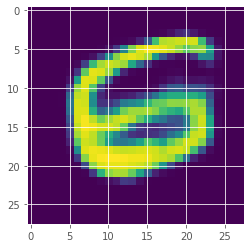

loss: 73.901482  [12800/60000]
KL_loss: 4.216114, recons_loss: 69.685371


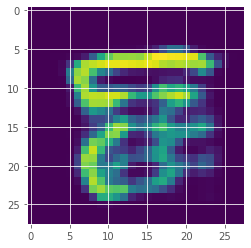

loss: 72.111900  [25600/60000]
KL_loss: 4.170350, recons_loss: 67.941536


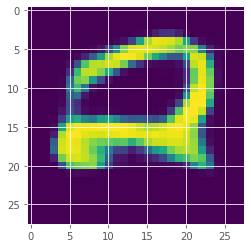

loss: 71.321823  [38400/60000]
KL_loss: 4.194619, recons_loss: 67.127197


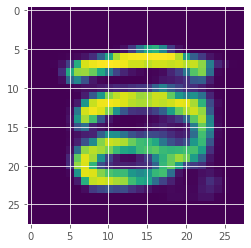

loss: 70.472679  [51200/60000]
KL_loss: 3.952979, recons_loss: 66.519714


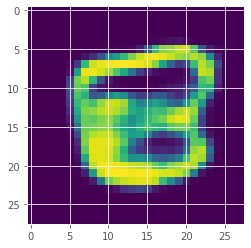

====> Average Train loss: 72.5574
====> Average Test loss: 72.1108
Validation loss decreased (72.220262 --> 72.110848).  Saving model ...
Epoch 56
-------------------------------
loss: 71.634720  [    0/60000]
KL_loss: 4.248590, recons_loss: 67.386139


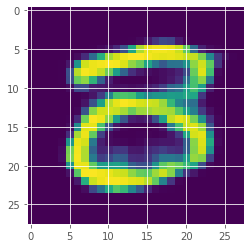

loss: 72.198601  [12800/60000]
KL_loss: 3.991965, recons_loss: 68.206627


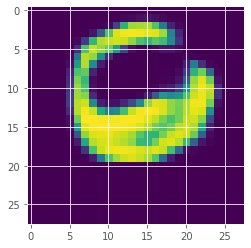

loss: 70.812103  [25600/60000]
KL_loss: 4.101975, recons_loss: 66.710121


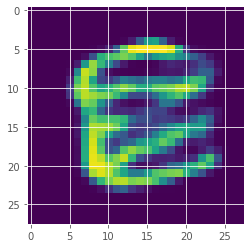

loss: 72.428123  [38400/60000]
KL_loss: 4.235898, recons_loss: 68.192223


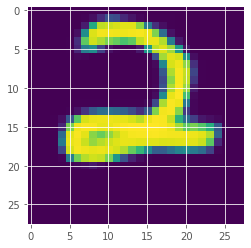

loss: 73.697372  [51200/60000]
KL_loss: 4.454625, recons_loss: 69.242744


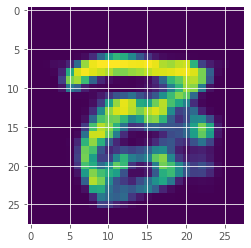

====> Average Train loss: 72.4958
====> Average Test loss: 72.1478
EarlyStopping counter: 1 out of 5
Epoch 57
-------------------------------
loss: 70.070892  [    0/60000]
KL_loss: 4.254679, recons_loss: 65.816216


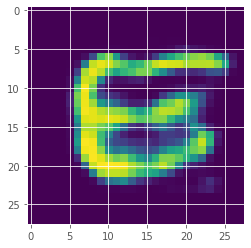

loss: 71.300552  [12800/60000]
KL_loss: 4.109239, recons_loss: 67.191307


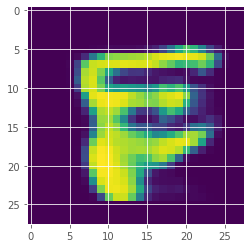

loss: 72.286392  [25600/60000]
KL_loss: 4.178800, recons_loss: 68.107605


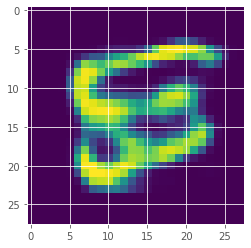

loss: 72.669922  [38400/60000]
KL_loss: 4.094809, recons_loss: 68.575119


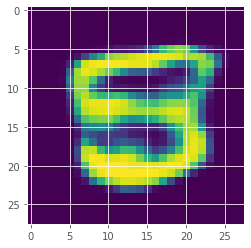

loss: 70.762001  [51200/60000]
KL_loss: 4.216738, recons_loss: 66.545265


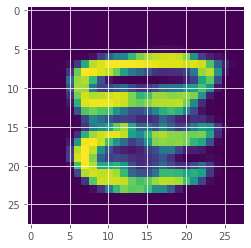

====> Average Train loss: 72.4045
====> Average Test loss: 72.3356
EarlyStopping counter: 2 out of 5
Epoch 58
-------------------------------
loss: 72.974113  [    0/60000]
KL_loss: 4.389223, recons_loss: 68.584900


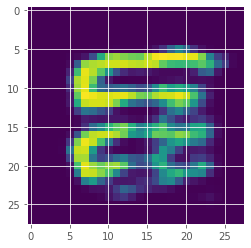

loss: 73.519188  [12800/60000]
KL_loss: 4.313072, recons_loss: 69.206116


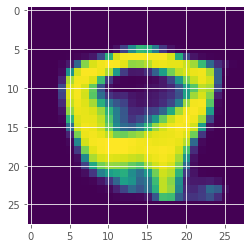

loss: 71.418404  [25600/60000]
KL_loss: 4.347270, recons_loss: 67.071129


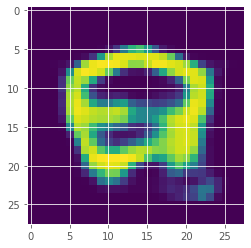

loss: 70.049347  [38400/60000]
KL_loss: 3.990314, recons_loss: 66.059036


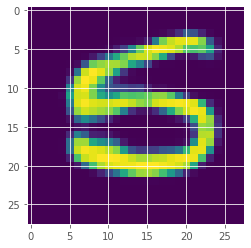

loss: 70.958588  [51200/60000]
KL_loss: 4.009363, recons_loss: 66.949226


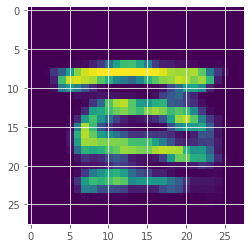

====> Average Train loss: 72.2778
====> Average Test loss: 72.0784
Validation loss decreased (72.110848 --> 72.078389).  Saving model ...
Epoch 59
-------------------------------
loss: 71.618713  [    0/60000]
KL_loss: 4.283962, recons_loss: 67.334755


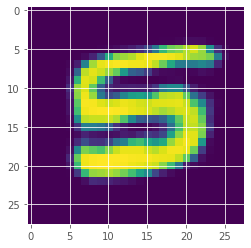

loss: 73.366455  [12800/60000]
KL_loss: 4.203848, recons_loss: 69.162598


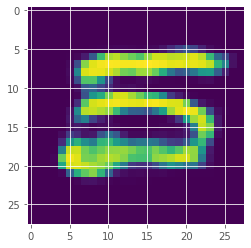

loss: 71.829491  [25600/60000]
KL_loss: 4.426153, recons_loss: 67.403343


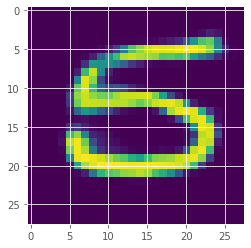

loss: 71.691872  [38400/60000]
KL_loss: 4.274536, recons_loss: 67.417320


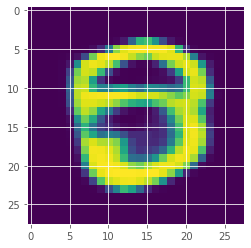

loss: 69.017349  [51200/60000]
KL_loss: 4.014712, recons_loss: 65.002647


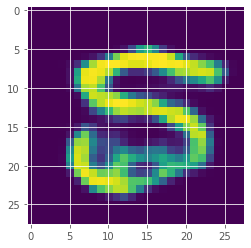

====> Average Train loss: 72.2308
====> Average Test loss: 71.9957
Validation loss decreased (72.078389 --> 71.995690).  Saving model ...
Epoch 60
-------------------------------
loss: 73.558609  [    0/60000]
KL_loss: 4.176383, recons_loss: 69.382233


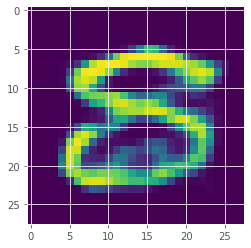

loss: 71.937630  [12800/60000]
KL_loss: 4.181581, recons_loss: 67.756042


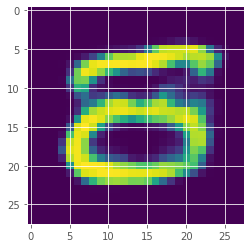

loss: 71.261360  [25600/60000]
KL_loss: 4.316179, recons_loss: 66.945175


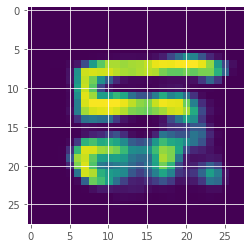

loss: 71.747665  [38400/60000]
KL_loss: 4.132350, recons_loss: 67.615295


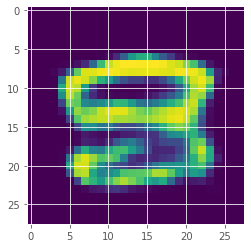

loss: 76.495865  [51200/60000]
KL_loss: 4.499519, recons_loss: 71.996338


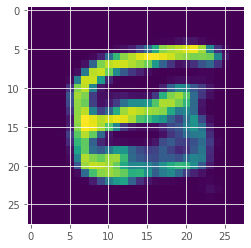

====> Average Train loss: 72.6360
====> Average Test loss: 72.3657
EarlyStopping counter: 1 out of 5
Epoch 61
-------------------------------
loss: 73.720253  [    0/60000]
KL_loss: 4.150048, recons_loss: 69.570213


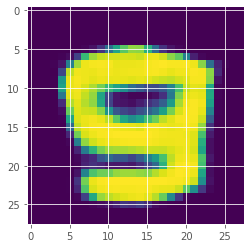

loss: 69.894905  [12800/60000]
KL_loss: 4.243802, recons_loss: 65.651108


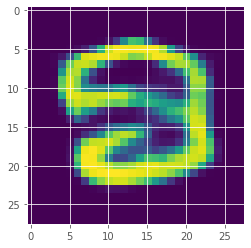

loss: 72.461403  [25600/60000]
KL_loss: 4.462646, recons_loss: 67.998749


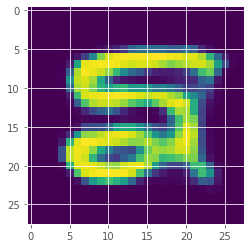

loss: 72.984108  [38400/60000]
KL_loss: 4.157156, recons_loss: 68.826935


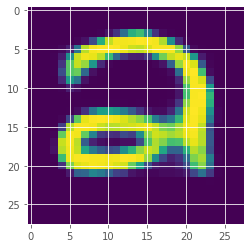

loss: 71.384567  [51200/60000]
KL_loss: 4.358074, recons_loss: 67.026505


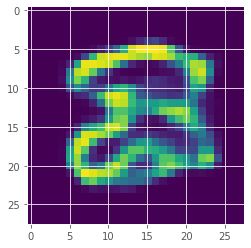

====> Average Train loss: 72.3681
====> Average Test loss: 72.6847
EarlyStopping counter: 2 out of 5
Epoch 62
-------------------------------
loss: 71.005943  [    0/60000]
KL_loss: 4.181162, recons_loss: 66.824799


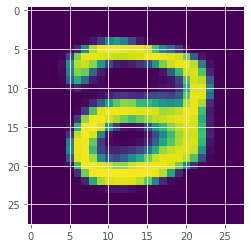

loss: 69.789101  [12800/60000]
KL_loss: 3.957516, recons_loss: 65.831573


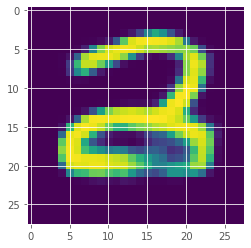

loss: 72.508667  [25600/60000]
KL_loss: 4.018939, recons_loss: 68.489723


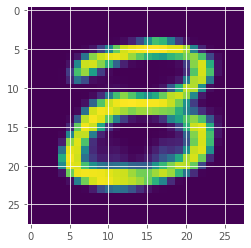

loss: 71.481087  [38400/60000]
KL_loss: 4.139472, recons_loss: 67.341621


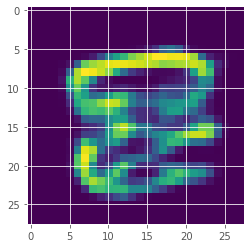

loss: 71.531197  [51200/60000]
KL_loss: 4.198667, recons_loss: 67.332535


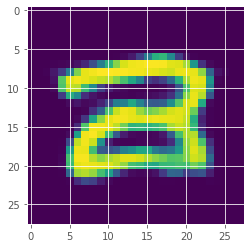

====> Average Train loss: 72.1388
====> Average Test loss: 71.9607
Validation loss decreased (71.995690 --> 71.960670).  Saving model ...
Epoch 63
-------------------------------
loss: 72.858124  [    0/60000]
KL_loss: 4.263290, recons_loss: 68.594818


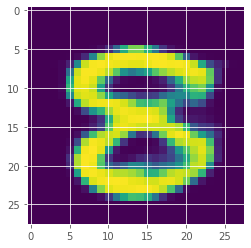

loss: 71.791672  [12800/60000]
KL_loss: 4.096480, recons_loss: 67.695168


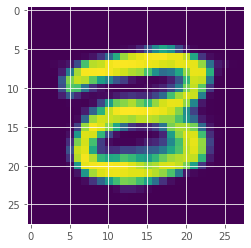

loss: 76.584381  [25600/60000]
KL_loss: 4.625623, recons_loss: 71.958763


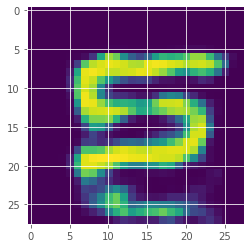

loss: 73.891289  [38400/60000]
KL_loss: 4.408719, recons_loss: 69.482574


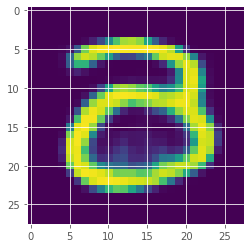

loss: 72.047447  [51200/60000]
KL_loss: 4.121721, recons_loss: 67.925728


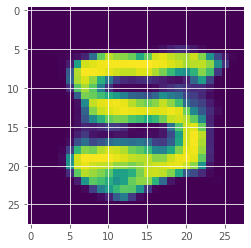

====> Average Train loss: 73.2620
====> Average Test loss: 72.1708
EarlyStopping counter: 1 out of 5
Epoch 64
-------------------------------
loss: 72.115532  [    0/60000]
KL_loss: 4.247389, recons_loss: 67.868141


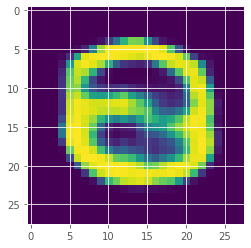

loss: 73.287941  [12800/60000]
KL_loss: 4.366415, recons_loss: 68.921516


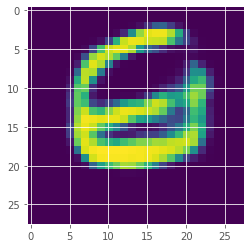

loss: 70.601746  [25600/60000]
KL_loss: 4.194311, recons_loss: 66.407433


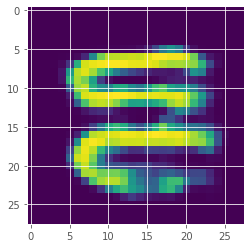

loss: 72.405724  [38400/60000]
KL_loss: 4.220649, recons_loss: 68.185074


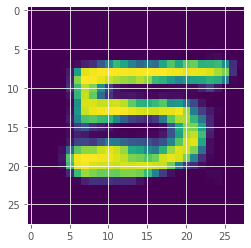

loss: 72.554588  [51200/60000]
KL_loss: 4.350153, recons_loss: 68.204445


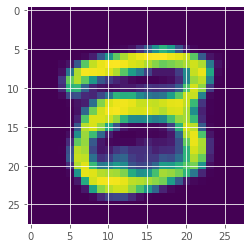

====> Average Train loss: 72.2075
====> Average Test loss: 71.8577
Validation loss decreased (71.960670 --> 71.857659).  Saving model ...
Epoch 65
-------------------------------
loss: 71.903084  [    0/60000]
KL_loss: 4.139187, recons_loss: 67.763908


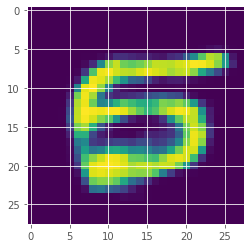

loss: 74.700981  [12800/60000]
KL_loss: 4.032535, recons_loss: 70.668442


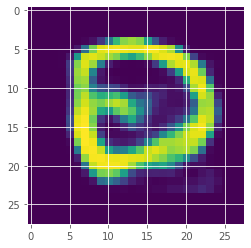

loss: 71.044586  [25600/60000]
KL_loss: 4.029543, recons_loss: 67.015045


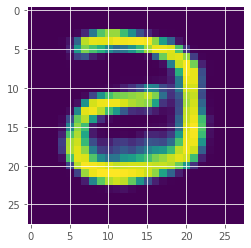

loss: 69.891342  [38400/60000]
KL_loss: 4.026252, recons_loss: 65.865097


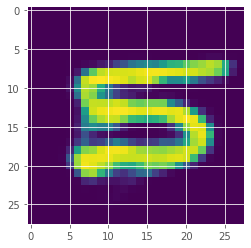

loss: 70.694756  [51200/60000]
KL_loss: 4.242572, recons_loss: 66.452194


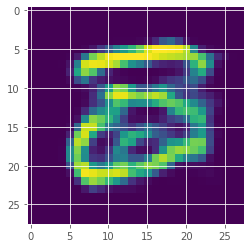

====> Average Train loss: 72.1601
====> Average Test loss: 71.8759
EarlyStopping counter: 1 out of 5
Epoch 66
-------------------------------
loss: 75.075806  [    0/60000]
KL_loss: 4.158882, recons_loss: 70.916931


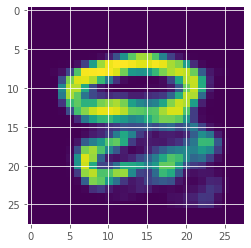

loss: 70.861664  [12800/60000]
KL_loss: 4.183229, recons_loss: 66.678436


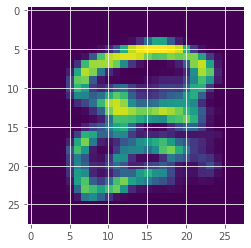

loss: 72.870834  [25600/60000]
KL_loss: 3.973019, recons_loss: 68.897827


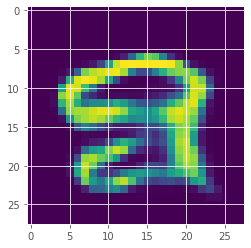

loss: 72.873764  [38400/60000]
KL_loss: 4.517010, recons_loss: 68.356743


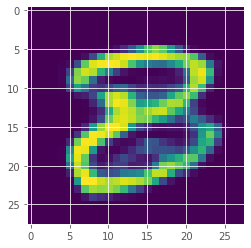

loss: 71.375877  [51200/60000]
KL_loss: 4.132861, recons_loss: 67.243027


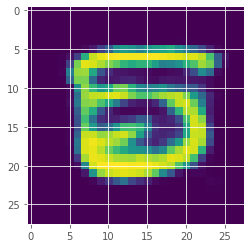

====> Average Train loss: 72.2948
====> Average Test loss: 72.0653
EarlyStopping counter: 2 out of 5
Epoch 67
-------------------------------
loss: 74.665077  [    0/60000]
KL_loss: 4.384351, recons_loss: 70.280731


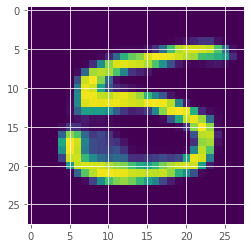

loss: 72.106720  [12800/60000]
KL_loss: 4.445357, recons_loss: 67.661346


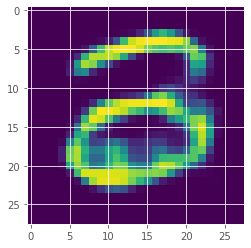

loss: 72.008507  [25600/60000]
KL_loss: 4.028207, recons_loss: 67.980301


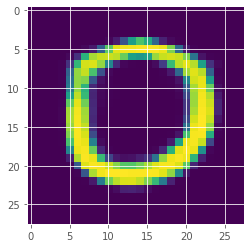

loss: 73.802887  [38400/60000]
KL_loss: 4.570510, recons_loss: 69.232384


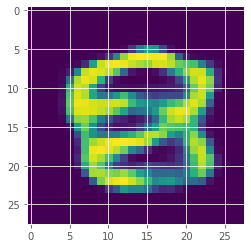

loss: 70.000114  [51200/60000]
KL_loss: 4.342429, recons_loss: 65.657684


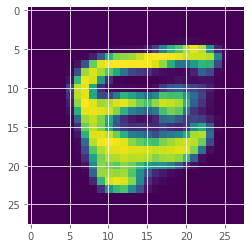

====> Average Train loss: 72.2498
====> Average Test loss: 71.8314
Validation loss decreased (71.857659 --> 71.831376).  Saving model ...
Epoch 68
-------------------------------
loss: 73.993004  [    0/60000]
KL_loss: 4.297700, recons_loss: 69.695320


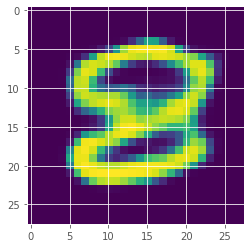

loss: 72.915367  [12800/60000]
KL_loss: 3.893323, recons_loss: 69.022041


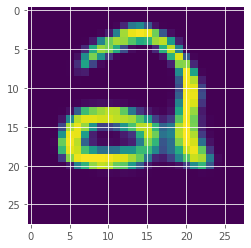

loss: 71.646843  [25600/60000]
KL_loss: 4.313504, recons_loss: 67.333344


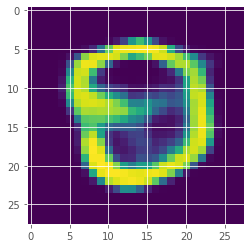

loss: 74.093597  [38400/60000]
KL_loss: 4.259624, recons_loss: 69.833984


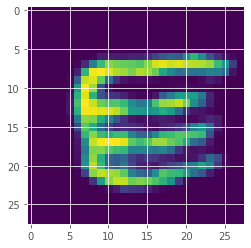

loss: 71.882324  [51200/60000]
KL_loss: 4.045169, recons_loss: 67.837151


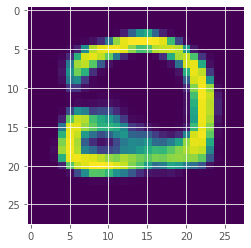

====> Average Train loss: 71.9292
====> Average Test loss: 71.6528
Validation loss decreased (71.831376 --> 71.652841).  Saving model ...
Epoch 69
-------------------------------
loss: 72.538162  [    0/60000]
KL_loss: 4.177546, recons_loss: 68.360611


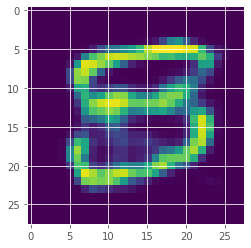

loss: 71.599747  [12800/60000]
KL_loss: 4.272336, recons_loss: 67.327415


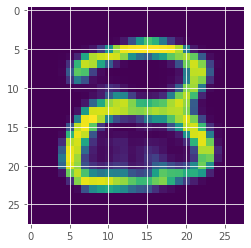

loss: 70.678062  [25600/60000]
KL_loss: 4.165260, recons_loss: 66.512802


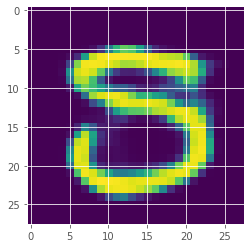

loss: 70.663727  [38400/60000]
KL_loss: 4.240502, recons_loss: 66.423210


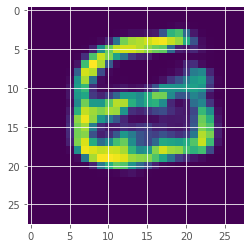

loss: 73.931633  [51200/60000]
KL_loss: 4.117995, recons_loss: 69.813622


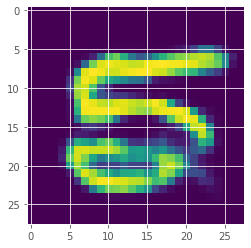

====> Average Train loss: 72.8999
====> Average Test loss: 73.2837
EarlyStopping counter: 1 out of 5
Epoch 70
-------------------------------
loss: 73.834892  [    0/60000]
KL_loss: 4.349536, recons_loss: 69.485352


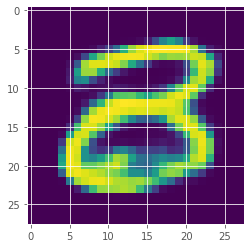

loss: 72.807129  [12800/60000]
KL_loss: 4.303097, recons_loss: 68.504051


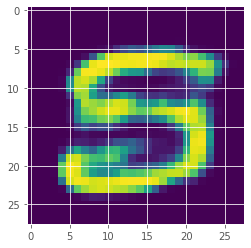

loss: 72.606827  [25600/60000]
KL_loss: 4.556449, recons_loss: 68.050369


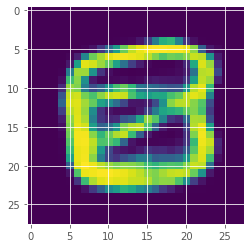

loss: 74.112091  [38400/60000]
KL_loss: 4.277712, recons_loss: 69.834373


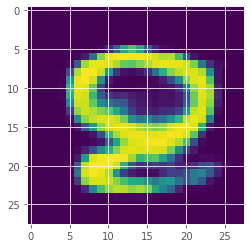

loss: 70.892265  [51200/60000]
KL_loss: 4.161130, recons_loss: 66.731148


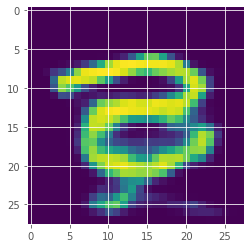

====> Average Train loss: 72.6666
====> Average Test loss: 72.0283
EarlyStopping counter: 2 out of 5
Epoch 71
-------------------------------
loss: 68.641754  [    0/60000]
KL_loss: 3.984416, recons_loss: 64.657341


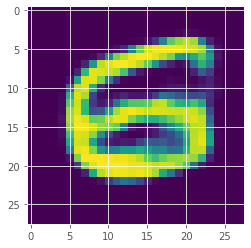

loss: 70.535568  [12800/60000]
KL_loss: 4.127351, recons_loss: 66.408226


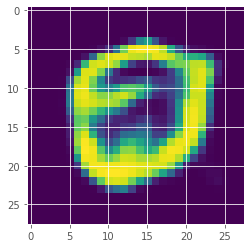

loss: 70.586266  [25600/60000]
KL_loss: 4.265287, recons_loss: 66.320984


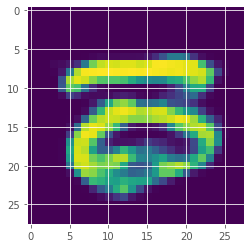

loss: 72.786613  [38400/60000]
KL_loss: 3.824547, recons_loss: 68.962074


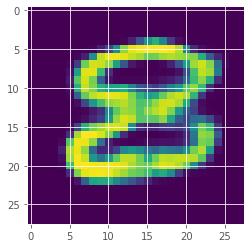

loss: 69.615952  [51200/60000]
KL_loss: 3.913199, recons_loss: 65.702751


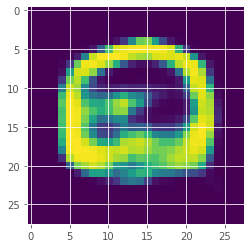

====> Average Train loss: 71.9821
====> Average Test loss: 71.7156
EarlyStopping counter: 3 out of 5
Epoch 72
-------------------------------
loss: 75.426880  [    0/60000]
KL_loss: 4.427001, recons_loss: 70.999886


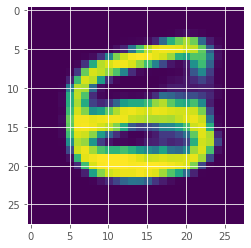

loss: 72.839127  [12800/60000]
KL_loss: 4.229298, recons_loss: 68.609825


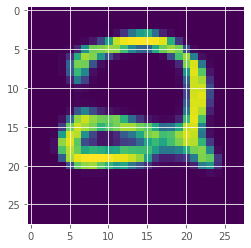

loss: 69.762466  [25600/60000]
KL_loss: 3.866818, recons_loss: 65.895645


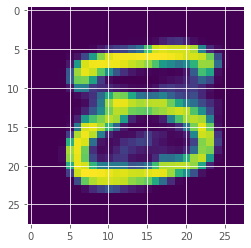

loss: 70.450104  [38400/60000]
KL_loss: 4.184329, recons_loss: 66.265778


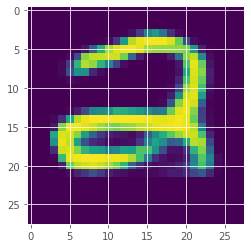

loss: 72.163521  [51200/60000]
KL_loss: 4.191941, recons_loss: 67.971573


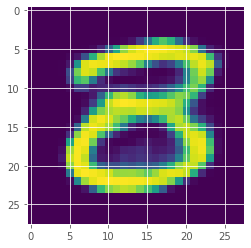

====> Average Train loss: 71.8188
====> Average Test loss: 71.6084
Validation loss decreased (71.652841 --> 71.608435).  Saving model ...
Epoch 73
-------------------------------
loss: 70.248146  [    0/60000]
KL_loss: 4.194113, recons_loss: 66.054039


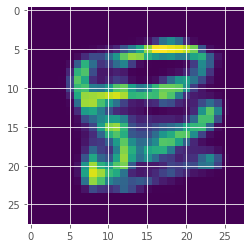

loss: 71.453438  [12800/60000]
KL_loss: 3.946099, recons_loss: 67.507324


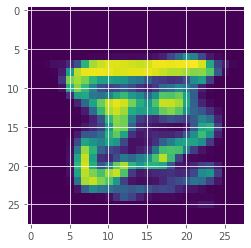

loss: 71.854851  [25600/60000]
KL_loss: 4.205403, recons_loss: 67.649460


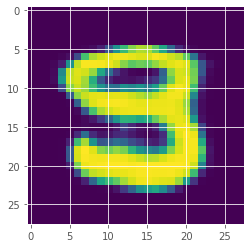

loss: 74.236855  [38400/60000]
KL_loss: 3.912579, recons_loss: 70.324287


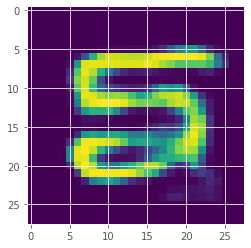

loss: 74.266663  [51200/60000]
KL_loss: 4.327507, recons_loss: 69.939156


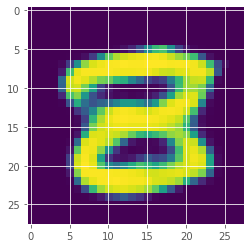

====> Average Train loss: 72.0009
====> Average Test loss: 76.1506
EarlyStopping counter: 1 out of 5
Epoch 74
-------------------------------
loss: 76.243904  [    0/60000]
KL_loss: 4.451418, recons_loss: 71.792480


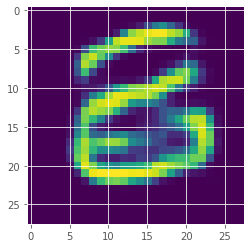

loss: 72.031708  [12800/60000]
KL_loss: 4.154134, recons_loss: 67.877571


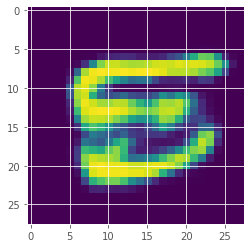

loss: 70.042519  [25600/60000]
KL_loss: 4.163889, recons_loss: 65.878632


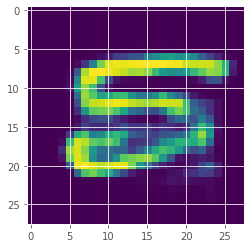

loss: 72.535561  [38400/60000]
KL_loss: 3.992538, recons_loss: 68.543030


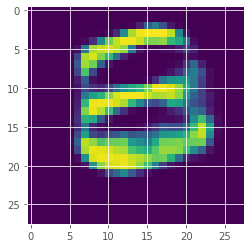

loss: 72.485039  [51200/60000]
KL_loss: 4.086261, recons_loss: 68.398766


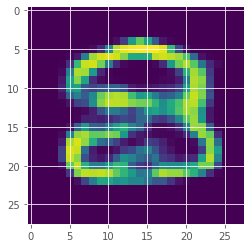

====> Average Train loss: 71.9399
====> Average Test loss: 71.4991
Validation loss decreased (71.608435 --> 71.499075).  Saving model ...
Epoch 75
-------------------------------
loss: 69.609627  [    0/60000]
KL_loss: 3.993076, recons_loss: 65.616539


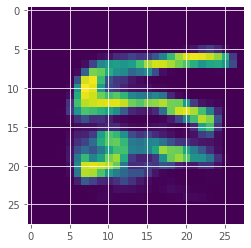

loss: 74.596481  [12800/60000]
KL_loss: 4.369683, recons_loss: 70.226791


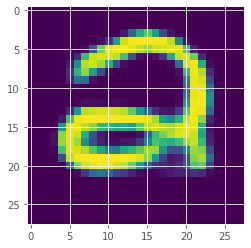

loss: 71.481422  [25600/60000]
KL_loss: 4.043350, recons_loss: 67.438072


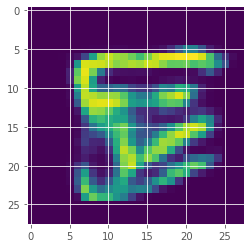

loss: 72.126938  [38400/60000]
KL_loss: 4.170793, recons_loss: 67.956161


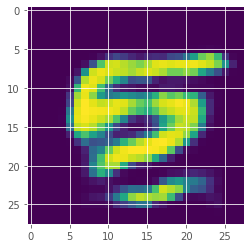

loss: 70.455811  [51200/60000]
KL_loss: 4.143127, recons_loss: 66.312675


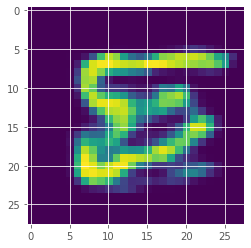

====> Average Train loss: 72.2595
====> Average Test loss: 71.7221
EarlyStopping counter: 1 out of 5
Epoch 76
-------------------------------
loss: 71.605629  [    0/60000]
KL_loss: 4.165096, recons_loss: 67.440529


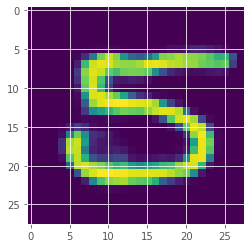

loss: 69.972679  [12800/60000]
KL_loss: 3.899562, recons_loss: 66.073105


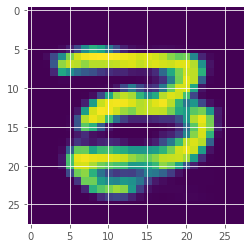

loss: 71.347191  [25600/60000]
KL_loss: 4.021920, recons_loss: 67.325264


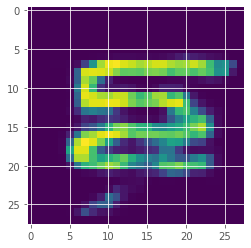

loss: 71.706711  [38400/60000]
KL_loss: 4.053736, recons_loss: 67.652992


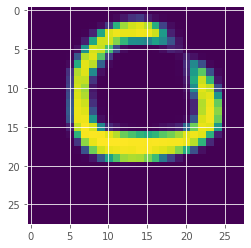

loss: 68.177895  [51200/60000]
KL_loss: 3.852449, recons_loss: 64.325455


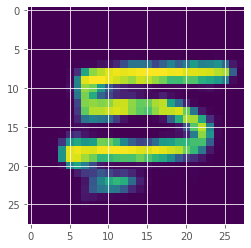

====> Average Train loss: 71.7206
====> Average Test loss: 71.6915
EarlyStopping counter: 2 out of 5
Epoch 77
-------------------------------
loss: 69.535652  [    0/60000]
KL_loss: 3.780627, recons_loss: 65.755013


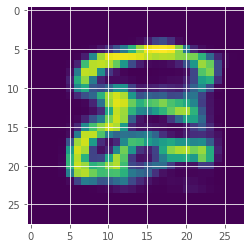

loss: 71.958855  [12800/60000]
KL_loss: 4.345926, recons_loss: 67.612907


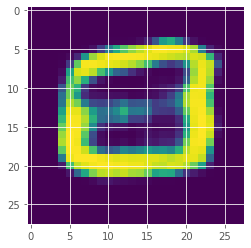

loss: 73.136353  [25600/60000]
KL_loss: 4.524366, recons_loss: 68.611992


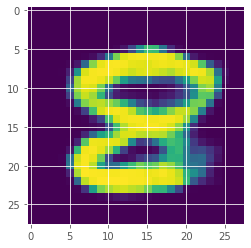

loss: 71.969009  [38400/60000]
KL_loss: 4.220403, recons_loss: 67.748596


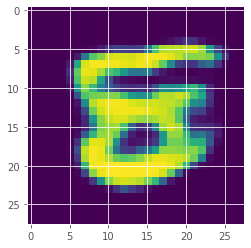

loss: 68.567474  [51200/60000]
KL_loss: 4.075758, recons_loss: 64.491707


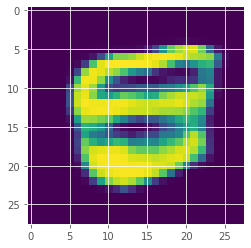

====> Average Train loss: 71.9599
====> Average Test loss: 71.4467
Validation loss decreased (71.499075 --> 71.446654).  Saving model ...
Epoch 78
-------------------------------
loss: 73.194473  [    0/60000]
KL_loss: 4.226365, recons_loss: 68.968102


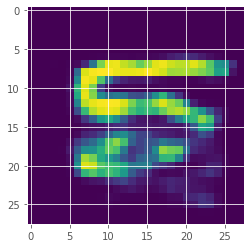

loss: 75.516319  [12800/60000]
KL_loss: 4.296711, recons_loss: 71.219620


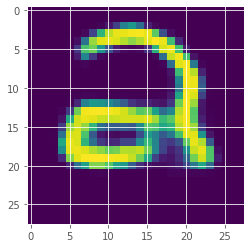

loss: 71.503227  [25600/60000]
KL_loss: 4.479686, recons_loss: 67.023544


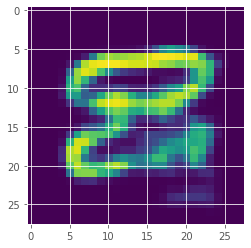

loss: 71.900536  [38400/60000]
KL_loss: 3.886884, recons_loss: 68.013657


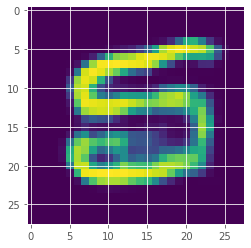

loss: 70.918533  [51200/60000]
KL_loss: 4.262383, recons_loss: 66.656151


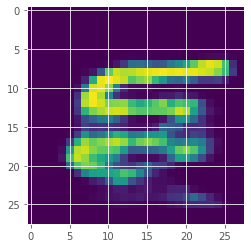

====> Average Train loss: 71.9358
====> Average Test loss: 71.6233
EarlyStopping counter: 1 out of 5
Epoch 79
-------------------------------
loss: 71.121437  [    0/60000]
KL_loss: 4.225092, recons_loss: 66.896355


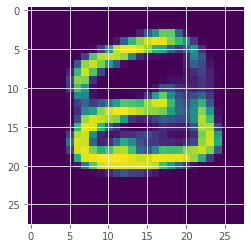

loss: 76.340179  [12800/60000]
KL_loss: 4.638564, recons_loss: 71.701607


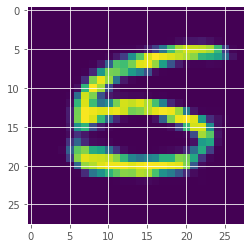

loss: 73.000328  [25600/60000]
KL_loss: 4.362094, recons_loss: 68.638222


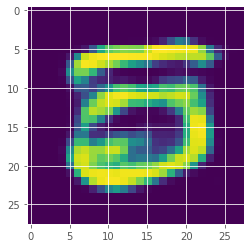

loss: 71.747322  [38400/60000]
KL_loss: 4.444352, recons_loss: 67.302948


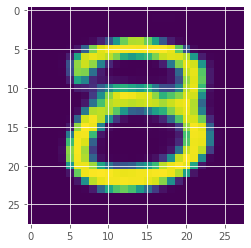

loss: 71.371048  [51200/60000]
KL_loss: 4.251839, recons_loss: 67.119202


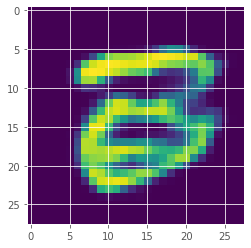

====> Average Train loss: 71.7651
====> Average Test loss: 71.6651
EarlyStopping counter: 2 out of 5
Epoch 80
-------------------------------
loss: 72.457420  [    0/60000]
KL_loss: 4.384671, recons_loss: 68.072754


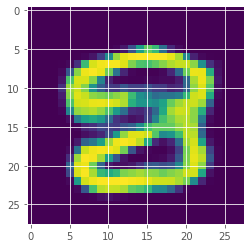

loss: 72.039856  [12800/60000]
KL_loss: 3.837379, recons_loss: 68.202484


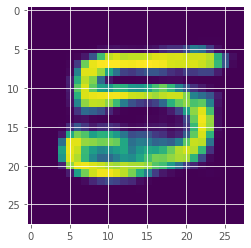

loss: 71.807358  [25600/60000]
KL_loss: 4.053018, recons_loss: 67.754341


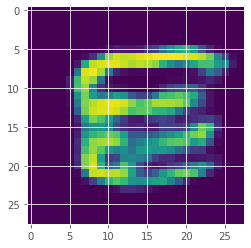

loss: 71.381279  [38400/60000]
KL_loss: 4.321196, recons_loss: 67.060074


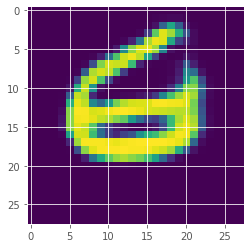

loss: 73.306595  [51200/60000]
KL_loss: 4.322970, recons_loss: 68.983620


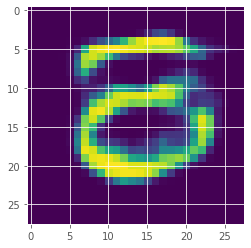

====> Average Train loss: 72.0092
====> Average Test loss: 75.7871
EarlyStopping counter: 3 out of 5
Epoch 81
-------------------------------
loss: 76.272530  [    0/60000]
KL_loss: 4.375641, recons_loss: 71.896889


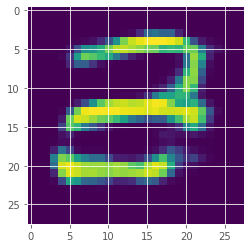

loss: 74.034538  [12800/60000]
KL_loss: 4.167531, recons_loss: 69.866997


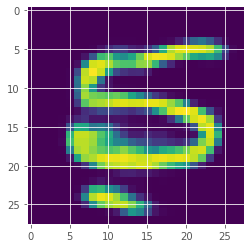

loss: 70.928146  [25600/60000]
KL_loss: 4.133188, recons_loss: 66.794945


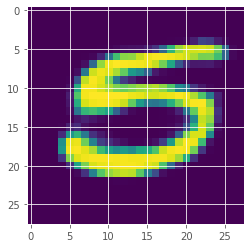

loss: 75.507858  [38400/60000]
KL_loss: 4.695825, recons_loss: 70.812027


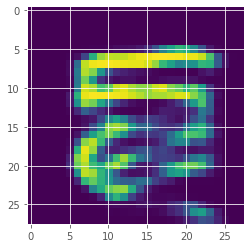

loss: 72.565781  [51200/60000]
KL_loss: 4.439892, recons_loss: 68.125900


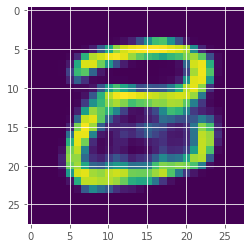

====> Average Train loss: 72.9496
====> Average Test loss: 72.1152
EarlyStopping counter: 4 out of 5
Epoch 82
-------------------------------
loss: 73.609055  [    0/60000]
KL_loss: 4.214837, recons_loss: 69.394234


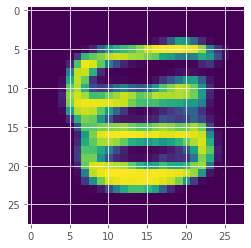

loss: 72.358917  [12800/60000]
KL_loss: 4.260038, recons_loss: 68.098877


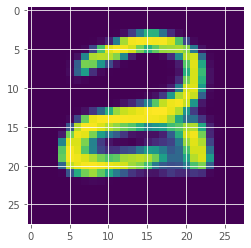

loss: 70.803635  [25600/60000]
KL_loss: 4.094465, recons_loss: 66.709160


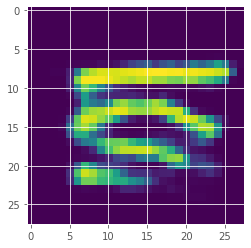

loss: 72.523628  [38400/60000]
KL_loss: 4.490862, recons_loss: 68.032753


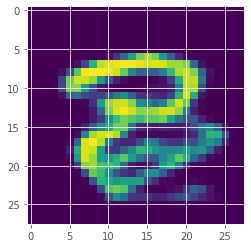

loss: 69.041725  [51200/60000]
KL_loss: 4.052178, recons_loss: 64.989525


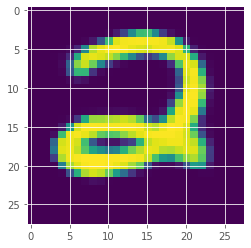

====> Average Train loss: 71.8279
====> Average Test loss: 71.6710
EarlyStopping counter: 5 out of 5
Early stopping
Execution complete


In [64]:
# set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
  
# instantiate the config class and set up the seeds    
conf = Config()
set_all_seeds(123)

# set up the data loaders
train_dataloader, test_dataloader = load_dataset(conf.batch_size)
  
# instantiate the model and set up the optimizer    
model = VRNN(conf.x_dim, conf.h_dim, conf.z_dim, conf.n_layers)
#model= nn.DataParallel(model, device_ids = conf.device_ids)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = conf.learning_rate)
    
# run model
model, train_loss, test_loss = execute(model, train_dataloader, test_dataloader, conf, device)

In [20]:
torch.cuda.memory_allocated()

512

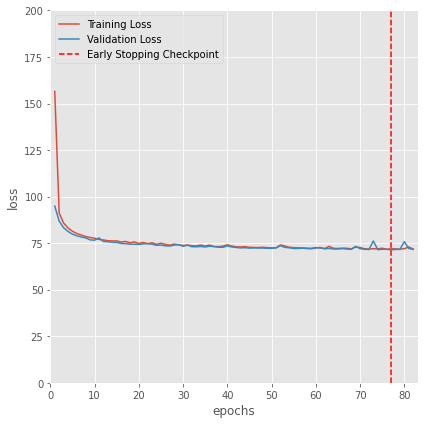

In [67]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(6,6))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(test_loss)+1),test_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = test_loss.index(min(test_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 200) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [20]:
# set the device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
  
# instantiate the config class and set up the seeds    
conf = Config()
set_all_seeds(123)

In [21]:
state_dict = torch.load('saves/checkpoint2.pt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VRNN(conf.x_dim, conf.h_dim, conf.z_dim, conf.n_layers)
model = model.to(device)
model.load_state_dict(state_dict)


<All keys matched successfully>

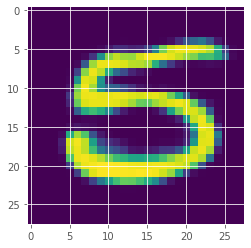

In [64]:
# generating samples from prior distribution
sample = model.sample(28, device)
plt.imshow(sample.cpu().detach().numpy())
plt.show()

In [ ]:
train_dataloader, test_dataloader = load_dataset(conf.batch_size)

In [28]:
# for getting the desired length subset of the dataset
#test_set = torch.utils.data.Subset(test_dataloader.dataset, range(0, 50))

In [29]:
def get_data(data_loader):
    dataiter = iter(data_loader)
    images, labels = dataiter.next()
    #print(images.size())  # ---> torch.Size([128, 1, 28, 28]) # batch_size number of images
    #print(images[0].size()) # ---> torch.Size([1, 28, 28])     # images[0] is the image at index 0 in the given batch
    #print(images[0].squeeze(0).size())  # ---> torch.Size([28, 28])
    return images, labels

In [21]:
images, labels = get_data(train_dataloader)
#images, labels = get_data(test_dataloader)

In [57]:
index = 3  # ranges from 0 to batch_size
x = images[index].squeeze(0)
x = x.to(device)
print("This image is of digit: ",labels[index].numpy())

This image is of digit:  3


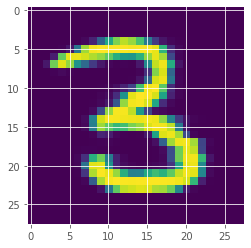

In [58]:
def show(x):
    reconstructed_image = model.reconstruction_from_posterior(x)
    plt.imshow(reconstructed_image.cpu().detach().numpy())
    plt.show()
    
show(x)

In [30]:
images, labels = get_data(test_dataloader)

In [35]:
index = 39 # ranges from 0 to batch_size
x = images[index].squeeze(0)
x = x.to(device)
print("This image is of digit: ",labels[index].numpy())

This image is of digit:  2


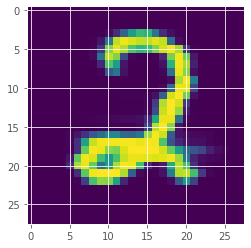

In [36]:
def show(x):
    reconstructed_image = model.reconstruction_from_posterior(x)
    plt.imshow(reconstructed_image.cpu().detach().numpy())
    plt.show()
    
show(x)